# PI 5º Semestre - Diabetes Prediction

## Grupo
* Eduarda Matos
* Igor Achette
* João Paulo Falcuci

## Descrição do Domínio
Conjunto de dados detalhado que compreende dados demográficos e de saúde de 100.000 indivíduos, com o objetivo de facilitar a pesquisa relacionada ao diabetes e a modelagem preditiva. Este conjunto de dados inclui informações sobre sexo, idade, localização, raça, hipertensão, doenças cardíacas, histórico de tabagismo, IMC, nível de HbA1c, nível de glicose no sangue e status de diabetes.

## Nome e link da base de dados
[Comprehensive Diabetes Clinical Dataset(100k rows)](https://www.kaggle.com/datasets/priyamchoksi/100000-diabetes-clinical-dataset)

## Informações da BD
### Quantidade de atributos
15 atributos:
* year - contínuo
* gender - discreto (Male | Female)
* age - contínuo
* location - discreto (55 estados)
* race:AfricanAmerican - discreto (0 | 1)
* race:Asian - discreto (0 | 1)
* race:Caucasian - discreto (0 | 1)
* race:Hispanic - discreto (0 | 1)
* race:Other - discreto (0 | 1)
* hypertension - discreto (0 | 1)
* heart_disease - discreto (0 | 1)
* smoking_history - discreto (current | ever | former | never | no info | not current)
* bmi - contínuo
* hbA1c_level - contínuo
* blood_glucose_level - contínuo

### Quantidade de exemplos
100.000 (cem mil) exemplos

### Se tem valores ausentes
A Base de Dados não possui valores ausentes

### Quantas e quais são as classes
**Diabetes - Duas classes**

* 0 (não possui)
* 1 (possui)

### Distribuição de classes
* 0 (não possui): 91.500
* 1 (possui): 8.500

# Pré processamento

## Carregando os dados

In [153]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from time import time

In [154]:
file = 'diabetes_dataset.csv'
df = pd.read_csv(f'./{file}', sep=',')
df.head()

year  gender   age location  race:AfricanAmerican  race:Asian  \
0  2020  Female  32.0  Alabama                     0           0   
1  2015  Female  29.0  Alabama                     0           1   
2  2015    Male  18.0  Alabama                     0           0   
3  2015    Male  41.0  Alabama                     0           0   
4  2016  Female  52.0  Alabama                     1           0   

   race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
0               0              0           1             0              0   
1               0              0           0             0              0   
2               0              0           1             0              0   
3               1              0           0             0              0   
4               0              0           0             0              0   

  smoking_history    bmi  hbA1c_level  blood_glucose_level  diabetes  
0           never  27.32          5.0                  100         0  
1           never  19.95          5.0                   90         0  
2           never  23.76          4.8                  160         0  
3           never  27.32          4.0                  159         0  
4           never  23.75          6.5                   90         0

## Pré-processamento: eliminação de atributos irrelevantes

Remoção da coluna 'year' pois é um dado que diz respeito ao ano em que o dado foi coletado, e não é relevante para a predição de diabetes.

In [155]:
df = df.drop(columns=['year'])
display(df.head(n=3))

gender   age location  race:AfricanAmerican  race:Asian  race:Caucasian  \
0  Female  32.0  Alabama                     0           0               0   
1  Female  29.0  Alabama                     0           1               0   
2    Male  18.0  Alabama                     0           0               0   

   race:Hispanic  race:Other  hypertension  heart_disease smoking_history  \
0              0           1             0              0           never   
1              0           0             0              0           never   
2              0           1             0              0           never   

     bmi  hbA1c_level  blood_glucose_level  diabetes  
0  27.32          5.0                  100         0  
1  19.95          5.0                   90         0  
2  23.76          4.8                  160         0

## Pré-processamento: codificação de atributos categóricos

Conversão do atributo 'gender' para valores binários e substituição do atributo 'smoking_history' por 6 novos atributos binários, um para cada valor possível.

In [156]:
# Codificação do atributo 'gender'
label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['location'] = label_encoder.fit_transform(df['location'])

# Usando pandas get_dummies para One-Hot Encoding para o atributo 'smoking_history'
df = pd.get_dummies(df, columns=['smoking_history'], drop_first=True)

# Convertendo valores booleanos para inteiros
numeric_columns = df.select_dtypes(include=[bool]).columns  # Seleciona colunas booleanas
df[numeric_columns] = df[numeric_columns].astype(int)  # Converte para inteiros

# Reordena o dataframe para que a classe 'diabetes' seja a última coluna
df = df[[c for c in df if c not in ['diabetes']] + ['diabetes']]

df.head()

gender   age  location  race:AfricanAmerican  race:Asian  race:Caucasian  \
0       0  32.0         0                     0           0               0   
1       0  29.0         0                     0           1               0   
2       1  18.0         0                     0           0               0   
3       1  41.0         0                     0           0               1   
4       0  52.0         0                     1           0               0   

   race:Hispanic  race:Other  hypertension  heart_disease    bmi  hbA1c_level  \
0              0           1             0              0  27.32          5.0   
1              0           0             0              0  19.95          5.0   
2              0           1             0              0  23.76          4.8   
3              0           0             0              0  27.32          4.0   
4              0           0             0              0  23.75          6.5   

   blood_glucose_level  smoking_history_current  smoking_history_ever  \
0                  100                        0                     0   
1                   90                        0                     0   
2                  160                        0                     0   
3                  159                        0                     0   
4                   90                        0                     0   

   smoking_history_former  smoking_history_never  smoking_history_not current  \
0                       0                      1                            0   
1                       0                      1                            0   
2                       0                      1                            0   
3                       0                      1                            0   
4                       0                      1                            0   

   diabetes  
0         0  
1         0  
2         0  
3         0  
4         0

Agora o atributo 'gender' possui os valores 0 (Female) e 1 (Male), 'location' possui valores de 0 a 54 e o atributo 'smoking_history' foi substituído pelos atributos 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never' e 'smoking_history_not_current'.

## Pré-processamento: comparação de relevância dos atributos

O atributo 'location' contém todos os estados americanos e possívelmente não é relevante para a predição de diabetes, então uma cópia do dataset será feita sem esse atributo para testar a relevância do mesmo.

In [157]:
df_without_location = df.drop(columns=['location'])
display(df_without_location.head(n=3))

gender   age  race:AfricanAmerican  race:Asian  race:Caucasian  \
0       0  32.0                     0           0               0   
1       0  29.0                     0           1               0   
2       1  18.0                     0           0               0   

   race:Hispanic  race:Other  hypertension  heart_disease    bmi  hbA1c_level  \
0              0           1             0              0  27.32          5.0   
1              0           0             0              0  19.95          5.0   
2              0           1             0              0  23.76          4.8   

   blood_glucose_level  smoking_history_current  smoking_history_ever  \
0                  100                        0                     0   
1                   90                        0                     0   
2                  160                        0                     0   

   smoking_history_former  smoking_history_never  smoking_history_not current  \
0                       0                      1                            0   
1                       0                      1                            0   
2                       0                      1                            0   

   diabetes  
0         0  
1         0  
2         0

A partir de agora, os dois datasets serão utilizados para treinar o modelo e comparar a relevância do atributo 'location'.

## Pré-processamento: tratamento de atributos com valores ausentes

In [158]:
# Índices das linhas que contém valores NaN
idxRowNan = pd.isnull(df).any(axis=1).to_numpy().nonzero()

if len(idxRowNan[0]) > 0:
  print(f'Linhas com valores NaN no dataset original:')
  display(df.iloc[idxRowNan])
else:
  print('Não há valores NaN no dataset original!')

idxRowNan = pd.isnull(df_without_location).any(axis=1).to_numpy().nonzero()

if len(idxRowNan[0]) > 0:
  print(f'Linhas com valores NaN no dataset sem a coluna "location":')
  display(df_without_location.iloc[idxRowNan])
else:
  print('Não há valores NaN no dataset sem a coluna "location"!')

Não há valores NaN no dataset original!
Não há valores NaN no dataset sem a coluna "location"!


## Pré-processamento: tratamento de dados inconsistentes ou redundantes

In [159]:
def delDuplicatas(df):
  '''
  Para cada grupo de amostras duplicadas, mantém uma e apaga as demais
  '''

  # Remove as amostras duplicadas, mantendo apenas a primeira ocorrencia
  df = df.drop_duplicates(keep = 'first')
  return df

attributes = ['gender', 'age', 'location', 'race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other', 'hypertension', 'heart_disease', 'bmi', 'hbA1c_level', 'blood_glucose_level', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']

In [160]:
df_duplicates = df[df.duplicated(subset=attributes, keep=False)]

# Se houver valores redundantes ou inconsistentes, imprima
if len(df_duplicates) > 0:
  print('Amostras redundantes ou inconsistentes:')
  display(df_duplicates)

  df = delDuplicatas(df)
  display(df)
else:
  print('Não existem valores duplicados')

Amostras redundantes ou inconsistentes:


gender   age  location  race:AfricanAmerican  race:Asian  \
2782        1  40.0         1                     0           0   
2848        1  40.0         1                     0           0   
21379       1  65.0        10                     0           1   
21662       1  65.0        10                     0           1   
23282       0  21.0        11                     0           1   
23313       0  21.0        11                     0           1   
25608       1  80.0        13                     0           1   
26317       1  80.0        13                     0           1   
32127       1  13.0        16                     0           1   
33506       1  13.0        16                     0           1   
37928       0  80.0        19                     0           0   
38483       0  80.0        19                     0           0   
42946       1  46.0        21                     0           1   
43401       1  46.0        21                     0           1   
46018       0  21.0        23                     0           0   
47208       0  21.0        23                     0           0   
47886       0  29.0        24                     1           0   
48472       0  29.0        24                     1           0   
51158       0  47.0        25                     1           0   
51351       0  47.0        25                     1           0   
57197       0  62.0        28                     1           0   
57881       0  62.0        28                     1           0   
59077       1  14.0        29                     0           1   
59507       1  14.0        29                     0           1   
61154       0  11.0        30                     0           1   
61867       0  11.0        30                     0           1   
64705       0  80.0        32                     1           0   
65311       0  80.0        32                     1           0   
70699       0  80.0        35                     0           0   
71285       0  80.0        35                     0           0   
73907       1  70.0        36                     0           0   
73971       1  70.0        36                     0           0   
75201       1  45.0        37                     0           0   
76007       1  45.0        37                     0           0   
78572       0  80.0        39                     0           0   
79192       1  12.0        39                     0           1   
79363       1  12.0        39                     0           1   
79726       0  80.0        39                     0           0   
81633       1  19.0        41                     0           0   
81939       1  19.0        41                     0           0   
84002       0  20.0        42                     0           1   
84085       0  20.0        42                     0           1   

       race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
2782                1              0           0             0              0   
2848                1              0           0             0              0   
21379               0              0           0             0              0   
21662               0              0           0             0              0   
23282               0              0           0             0              0   
23313               0              0           0             0              0   
25608               0              0           0             0              0   
26317               0              0           0             0              0   
32127               0              0           0             0              0   
33506               0              0           0             0              0   
37928               1              0           0             0              0   
38483               1              0           0             0              0   
42946               0              0           0             0          

gender   age  location  race:AfricanAmerican  race:Asian  \
0           0  32.0         0                     0           0   
1           0  29.0         0                     0           1   
2           1  18.0         0                     0           0   
3           1  41.0         0                     0           0   
4           0  52.0         0                     1           0   
...       ...   ...       ...                   ...         ...   
99995       0  33.0        54                     0           0   
99996       0  80.0        54                     0           1   
99997       1  46.0        54                     0           1   
99998       0  51.0        54                     1           0   
99999       1  13.0        54                     0           0   

       race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
0                   0              0           1             0              0   
1                   0              0           0             0              0   
2                   0              0           1             0              0   
3                   1              0           0             0              0   
4                   0              0           0             0              0   
...               ...            ...         ...           ...            ...   
99995               0              0           1             0              0   
99996               0              0           0             0              0   
99997               0              0           0             0              0   
99998               0              0           0             0              0   
99999               0              1           0             0              0   

         bmi  hbA1c_level  blood_glucose_level  smoking_history_current  \
0      27.32          5.0                  100                        0   
1      19.95          5.0                   90                        0   
2      23.76          4.8                  160                        0   
3      27.32          4.0                  159                        0   
4      23.75          6.5                   90                        0   
...      ...          ...                  ...                      ...   
99995  21.21          6.5                   90                        0   
99996  36.66          5.7                  100                        0   
99997  36.12          6.2                  158                        0   
99998  29.29          6.0                  155                        0   
99999  17.16          5.0                   90                        0   

       smoking_history_ever  smoking_history_former  smoking_history_never  \
0                         0                       0                      1   
1                         0                       0                      1   
2                         0                       0                      1   
3                         0                       0                      1   
4                         0                       0                      1   
...                     ...                     ...                    ...   
99995                     0                       0                      1   
99996                     0                       0                      0   
99997                     1                       0                      0   
99998                     0                       0                      0   
99999                     0                       0                      0   

       smoking_history_not current  diabetes  
0                                0         0  
1                                0         0  
2                                0         0  
3                                0         0  
4                                0         0  
...                            ...       ...  
99995                            0         0  
99996          

In [161]:
# Para detectar inconsistências, a rotina abaixo obtém as amostras onde os valores dos atributos continuam duplicados
# Neste caso, os atributos serão iguais, mas as classes serão distintas
df_duplicates = df[df.duplicated(subset=attributes, keep=False)]

# Se tiver valores inconsistentes, imprime
if len(df_duplicates) > 0:
  print('Amostras inconsistentes:')
  display(df_duplicates)
else:
  print('Não existem mostras inconsistentes')

Amostras inconsistentes:


gender   age  location  race:AfricanAmerican  race:Asian  \
51158       0  47.0        25                     1           0   
51351       0  47.0        25                     1           0   

       race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
51158               0              0           0             0              0   
51351               0              0           0             0              0   

         bmi  hbA1c_level  blood_glucose_level  smoking_history_current  \
51158  27.32          6.0                  145                        0   
51351  27.32          6.0                  145                        0   

       smoking_history_ever  smoking_history_former  smoking_history_never  \
51158                     0                       0                      0   
51351                     0                       0                      0   

       smoking_history_not current  diabetes  
51158                            0         1  
51351                            0         0

In [162]:
def delInconsistencias(df):
  '''
  Remove todas as amostras inconsistentes da base de dados
  '''

  df = df.drop_duplicates(subset=attributes, keep = False)
  return df

In [163]:
df = delInconsistencias(df)

# Obtém apenas as amostras onde os valores dos atributos estão duplicados
df_duplicates = df[df.duplicated(subset=attributes, keep=False)]

# Se ainda tiver valores redundantes ou inconsistentes, imprime
if len(df_duplicates) > 0:
  display(df_duplicates)
else:
  print('Não existem amostras redundantes ou inconsistentes')

Não existem amostras redundantes ou inconsistentes


In [164]:
# Apresenta as principais estatísticas da base de dados
df.describe()

gender           age      location  race:AfricanAmerican  \
count  99978.000000  99978.000000  99978.000000          99978.000000   
mean       0.414651     41.885251     24.748115              0.202224   
std        0.493030     22.516080     14.787041              0.401661   
min        0.000000      0.080000      0.000000              0.000000   
25%        0.000000     24.000000     12.000000              0.000000   
50%        0.000000     43.000000     25.000000              0.000000   
75%        1.000000     60.000000     37.000000              0.000000   
max        2.000000     80.000000     54.000000              1.000000   

         race:Asian  race:Caucasian  race:Hispanic    race:Other  \
count  99978.000000    99978.000000   99978.000000  99978.000000   
mean       0.200104        0.198764       0.198914      0.199994   
std        0.400080        0.399072       0.399185      0.399997   
min        0.000000        0.000000       0.000000      0.000000   
25%        0.000000        0.000000       0.000000      0.000000   
50%        0.000000        0.000000       0.000000      0.000000   
75%        0.000000        0.000000       0.000000      0.000000   
max        1.000000        1.000000       1.000000      1.000000   

       hypertension  heart_disease           bmi   hbA1c_level  \
count  99978.000000   99978.000000  99978.000000  99978.000000   
mean       0.074866       0.039429     27.320767      5.527524   
std        0.263177       0.194614      6.637514      1.070683   
min        0.000000       0.000000     10.010000      3.500000   
25%        0.000000       0.000000     23.630000      4.800000   
50%        0.000000       0.000000     27.320000      5.800000   
75%        0.000000       0.000000     29.580000      6.200000   
max        1.000000       1.000000     95.690000      9.000000   

       blood_glucose_level  smoking_history_current  smoking_history_ever  \
count         99978.000000             99978.000000          99978.000000   
mean            138.060123                 0.092880              0.040049   
std              40.709402                 0.290266              0.196075   
min              80.000000                 0.000000              0.000000   
25%             100.000000                 0.000000              0.000000   
50%             140.000000                 0.000000              0.000000   
75%             159.000000                 0.000000              0.000000   
max             300.000000                 1.000000              1.000000   

       smoking_history_former  smoking_history_never  \
count            99978.000000           99978.000000   
mean                 0.093541               0.350967   
std                  0.291190               0.477275   
min                  0.000000               0.000000   
25%                  0.000000               0.000000   
50%                  0.000000               0.000000   
75%                  0.000000               1.000000   
max                  1.000000               1.000000   

       smoking_history_not current      diabetes  
count                 99978.000000  99978.000000  
mean                      0.064484      0.085009  
std                       0.245615      0.278896  
min                       0.000000      0.000000  
25%                       0.000000      0.000000  
50%                       0.000000      0.000000  
75%                       0.000000      0.000000  
max                       1.000000      1.000000

Aplicando o mesmo tratamento ao dataset sem o atributo 'location'.

In [165]:
# Removendo 'location' de attributes
attributes.remove('location')

df_duplicates = df_without_location[df_without_location.duplicated(subset=attributes, keep=False)]

# Se houver valores redundantes ou inconsistentes, imprima
if len(df_duplicates) > 0:
  print('Amostras redundantes ou inconsistentes:')
  display(df_duplicates)

  df_without_location = delDuplicatas(df_without_location)
  display(df_without_location)
else:
  print('Não existem valores duplicados')

Amostras redundantes ou inconsistentes:


gender   age  race:AfricanAmerican  race:Asian  race:Caucasian  \
17          1  80.0                     0           0               0   
90          0  80.0                     0           0               0   
100         0  80.0                     0           0               0   
232         0  31.0                     1           0               0   
234         1  78.0                     0           1               0   
...       ...   ...                   ...         ...             ...   
99317       0  80.0                     1           0               0   
99430       1  60.0                     1           0               0   
99467       1  34.0                     0           0               0   
99582       0  42.0                     0           0               1   
99597       0  24.0                     1           0               0   

       race:Hispanic  race:Other  hypertension  heart_disease    bmi  \
17                 0           1             0              0  27.32   
90                 1           0             1              0  27.32   
100                0           1             1              0  27.32   
232                0           0             0              0  27.32   
234                0           0             0              0  27.32   
...              ...         ...           ...            ...    ...   
99317              0           0             0              0  27.32   
99430              0           0             0              0  27.32   
99467              0           1             0              0  27.32   
99582              0           0             0              0  27.32   
99597              0           0             0              0  27.32   

       hbA1c_level  blood_glucose_level  smoking_history_current  \
17             6.0                  130                        0   
90             4.8                   90                        0   
100            4.5                   85                        0   
232            6.1                   85                        0   
234            3.5                  140                        0   
...            ...                  ...                      ...   
99317          4.5                  155                        0   
99430          6.6                  160                        0   
99467          6.6                   90                        0   
99582          5.8                  159                        0   
99597          5.0                   80                        1   

       smoking_history_ever  smoking_history_former  smoking_history_never  \
17                        0                       0                      0   
90                        0                       0                      1   
100                       0                       0                      0   
232                       0                       0                      1   
234                       0                       0                      0   
...                     ...                     ...                    ...   
99317                     0                       0                      0   
99430                     0                       0                      0   
99467                     0                       0                      0   
99582                     0                       0                      0   
99597                     0                       0                      0   

       smoking_history_not current  diabetes  
17                               0         0  
90                               0         0  
100                              0         0  
232                              0         0  
234                              0         0  
...                            ...       ...  
99317                            0         0  
99430                            0         0  
99467                            0         0  
99582                            0       

gender   age  race:AfricanAmerican  race:Asian  race:Caucasian  \
0           0  32.0                     0           0               0   
1           0  29.0                     0           1               0   
2           1  18.0                     0           0               0   
3           1  41.0                     0           0               1   
4           0  52.0                     1           0               0   
...       ...   ...                   ...         ...             ...   
99995       0  33.0                     0           0               0   
99996       0  80.0                     0           1               0   
99997       1  46.0                     0           1               0   
99998       0  51.0                     1           0               0   
99999       1  13.0                     0           0               0   

       race:Hispanic  race:Other  hypertension  heart_disease    bmi  \
0                  0           1             0              0  27.32   
1                  0           0             0              0  19.95   
2                  0           1             0              0  23.76   
3                  0           0             0              0  27.32   
4                  0           0             0              0  23.75   
...              ...         ...           ...            ...    ...   
99995              0           1             0              0  21.21   
99996              0           0             0              0  36.66   
99997              0           0             0              0  36.12   
99998              0           0             0              0  29.29   
99999              1           0             0              0  17.16   

       hbA1c_level  blood_glucose_level  smoking_history_current  \
0              5.0                  100                        0   
1              5.0                   90                        0   
2              4.8                  160                        0   
3              4.0                  159                        0   
4              6.5                   90                        0   
...            ...                  ...                      ...   
99995          6.5                   90                        0   
99996          5.7                  100                        0   
99997          6.2                  158                        0   
99998          6.0                  155                        0   
99999          5.0                   90                        0   

       smoking_history_ever  smoking_history_former  smoking_history_never  \
0                         0                       0                      1   
1                         0                       0                      1   
2                         0                       0                      1   
3                         0                       0                      1   
4                         0                       0                      1   
...                     ...                     ...                    ...   
99995                     0                       0                      1   
99996                     0                       0                      0   
99997                     1                       0                      0   
99998                     0                       0                      0   
99999                     0                       0                      0   

       smoking_history_not current  diabetes  
0                                0         0  
1                                0         0  
2                                0         0  
3                                0         0  
4                                0         0  
...                            ...       ...  
99995                            0         0  
99996                            0         0  
99997                            0         0  
99998                            1       

In [166]:
# Para detectar inconsistências, a rotina abaixo obtém as amostras onde os valores dos atributos continuam duplicados
# Neste caso, os atributos serão iguais, mas as classes serão distintas
df_duplicates = df_without_location[df_without_location.duplicated(subset=attributes, keep=False)]

# Se tiver valores inconsistentes, imprime
if len(df_duplicates)>0:
  print('Amostras inconsistentes:')
  display(df_duplicates)
else:
  print('Não existem mostras inconsistentes')

Amostras inconsistentes:


gender   age  race:AfricanAmerican  race:Asian  race:Caucasian  \
1448        0  80.0                     0           0               0   
2971        1  66.0                     1           0               0   
3194        0  61.0                     0           0               0   
5459        0  80.0                     0           0               0   
6685        0  80.0                     0           0               0   
11321       1  66.0                     0           0               0   
14196       1  51.0                     0           0               0   
18811       1  69.0                     0           0               1   
18813       1  73.0                     0           0               1   
19956       0  80.0                     0           0               1   
20328       0  28.0                     0           0               1   
24682       0  61.0                     1           0               0   
28955       1  44.0                     1           0               0   
30448       1  32.0                     0           0               0   
30506       1  65.0                     1           0               0   
32148       0  80.0                     0           0               1   
35896       1  69.0                     0           0               1   
38737       1  80.0                     1           0               0   
39038       1  32.0                     0           0               0   
41305       1  55.0                     0           0               0   
42241       1  66.0                     1           0               0   
42514       0  80.0                     0           0               0   
45224       0  68.0                     0           0               0   
50711       0  28.0                     0           0               1   
51158       0  47.0                     1           0               0   
51240       0  80.0                     0           0               0   
51351       0  47.0                     1           0               0   
51387       0  49.0                     0           0               0   
52848       0  51.0                     0           1               0   
53152       1  65.0                     1           0               0   
55077       0  61.0                     1           0               0   
55633       0  43.0                     0           1               0   
56931       1  80.0                     0           0               1   
57033       0  80.0                     1           0               0   
58220       0  51.0                     0           1               0   
61597       1  66.0                     0           0               0   
62223       0  80.0                     0           0               0   
62876       1  80.0                     0           0               1   
67388       0  68.0                     0           0               0   
71424       1  44.0                     1           0               0   
76078       0  43.0                     0           1               0   
78572       0  80.0                     0           0               0   
81190       1  80.0                     1           0               0   
83097       1  55.0                     0           0               0   
86584       0  80.0                     1           0               0   
87626       0  49.0                     0           0               0   
88260       0  61.0                     0           0               0   
92772       0  80.0                     0           0               0   
93388       1  56.0                     1           0               0   
94712       1  51.0                     0           0               0   
95552       1  56.0                     1           0               0   
96356       1  73.0                     0           0               1   

       race:Hispanic  race:Other  hypertension  heart_disease    bmi  \
1448               0           1             0              0  27

In [167]:
df_without_location = delInconsistencias(df_without_location)

# Obtém apenas as amostras onde os valores dos atributos estão duplicados
df_duplicates = df_without_location[df_without_location.duplicated(subset=attributes, keep=False)]

# Se ainda tiver valores redundantes ou inconsistentes, imprime
if len(df_duplicates) > 0:
  display(df_duplicates)
else:
  print('Não existem amostras redundantes ou inconsistentes')

Não existem amostras redundantes ou inconsistentes


In [168]:
# Apresenta as principais estatísticas da base de dados
df_without_location.describe()

gender           age  race:AfricanAmerican    race:Asian  \
count  99048.000000  99048.000000          99048.000000  99048.000000   
mean       0.415263     41.831687              0.202175      0.200095   
std        0.493139     22.483704              0.401624      0.400073   
min        0.000000      0.080000              0.000000      0.000000   
25%        0.000000     24.000000              0.000000      0.000000   
50%        0.000000     43.000000              0.000000      0.000000   
75%        1.000000     59.000000              0.000000      0.000000   
max        2.000000     80.000000              1.000000      1.000000   

       race:Caucasian  race:Hispanic    race:Other  hypertension  \
count    99048.000000   99048.000000  99048.000000  99048.000000   
mean         0.198823       0.198974      0.199933      0.075499   
std          0.399116       0.399231      0.399952      0.264196   
min          0.000000       0.000000      0.000000      0.000000   
25%          0.000000       0.000000      0.000000      0.000000   
50%          0.000000       0.000000      0.000000      0.000000   
75%          0.000000       0.000000      0.000000      0.000000   
max          1.000000       1.000000      1.000000      1.000000   

       heart_disease           bmi   hbA1c_level  blood_glucose_level  \
count   99048.000000  99048.000000  99048.000000         99048.000000   
mean        0.039759     27.320827      5.528658           138.086110   
std         0.195392      6.668487      1.071325            40.763163   
min         0.000000     10.010000      3.500000            80.000000   
25%         0.000000     23.580000      4.800000           100.000000   
50%         0.000000     27.320000      5.800000           140.000000   
75%         0.000000     29.640000      6.200000           159.000000   
max         1.000000     95.690000      9.000000           300.000000   

       smoking_history_current  smoking_history_ever  smoking_history_former  \
count             99048.000000          99048.000000            99048.000000   
mean                  0.093551              0.040425                0.094338   
std                   0.291204              0.196954                0.292300   
min                   0.000000              0.000000                0.000000   
25%                   0.000000              0.000000                0.000000   
50%                   0.000000              0.000000                0.000000   
75%                   0.000000              0.000000                0.000000   
max                   1.000000              1.000000                1.000000   

       smoking_history_never  smoking_history_not current      diabetes  
count           99048.000000                 99048.000000  99048.000000  
mean                0.352718                     0.064908      0.085544  
std                 0.477818                     0.246365      0.279691  
min                 0.000000                     0.000000      0.000000  
25%                 0.000000                     0.000000      0.000000  
50%                 0.000000                     0.000000      0.000000  
75%                 1.000000                     0.000000      0.000000  
max                 1.000000                     1.000000      1.000000

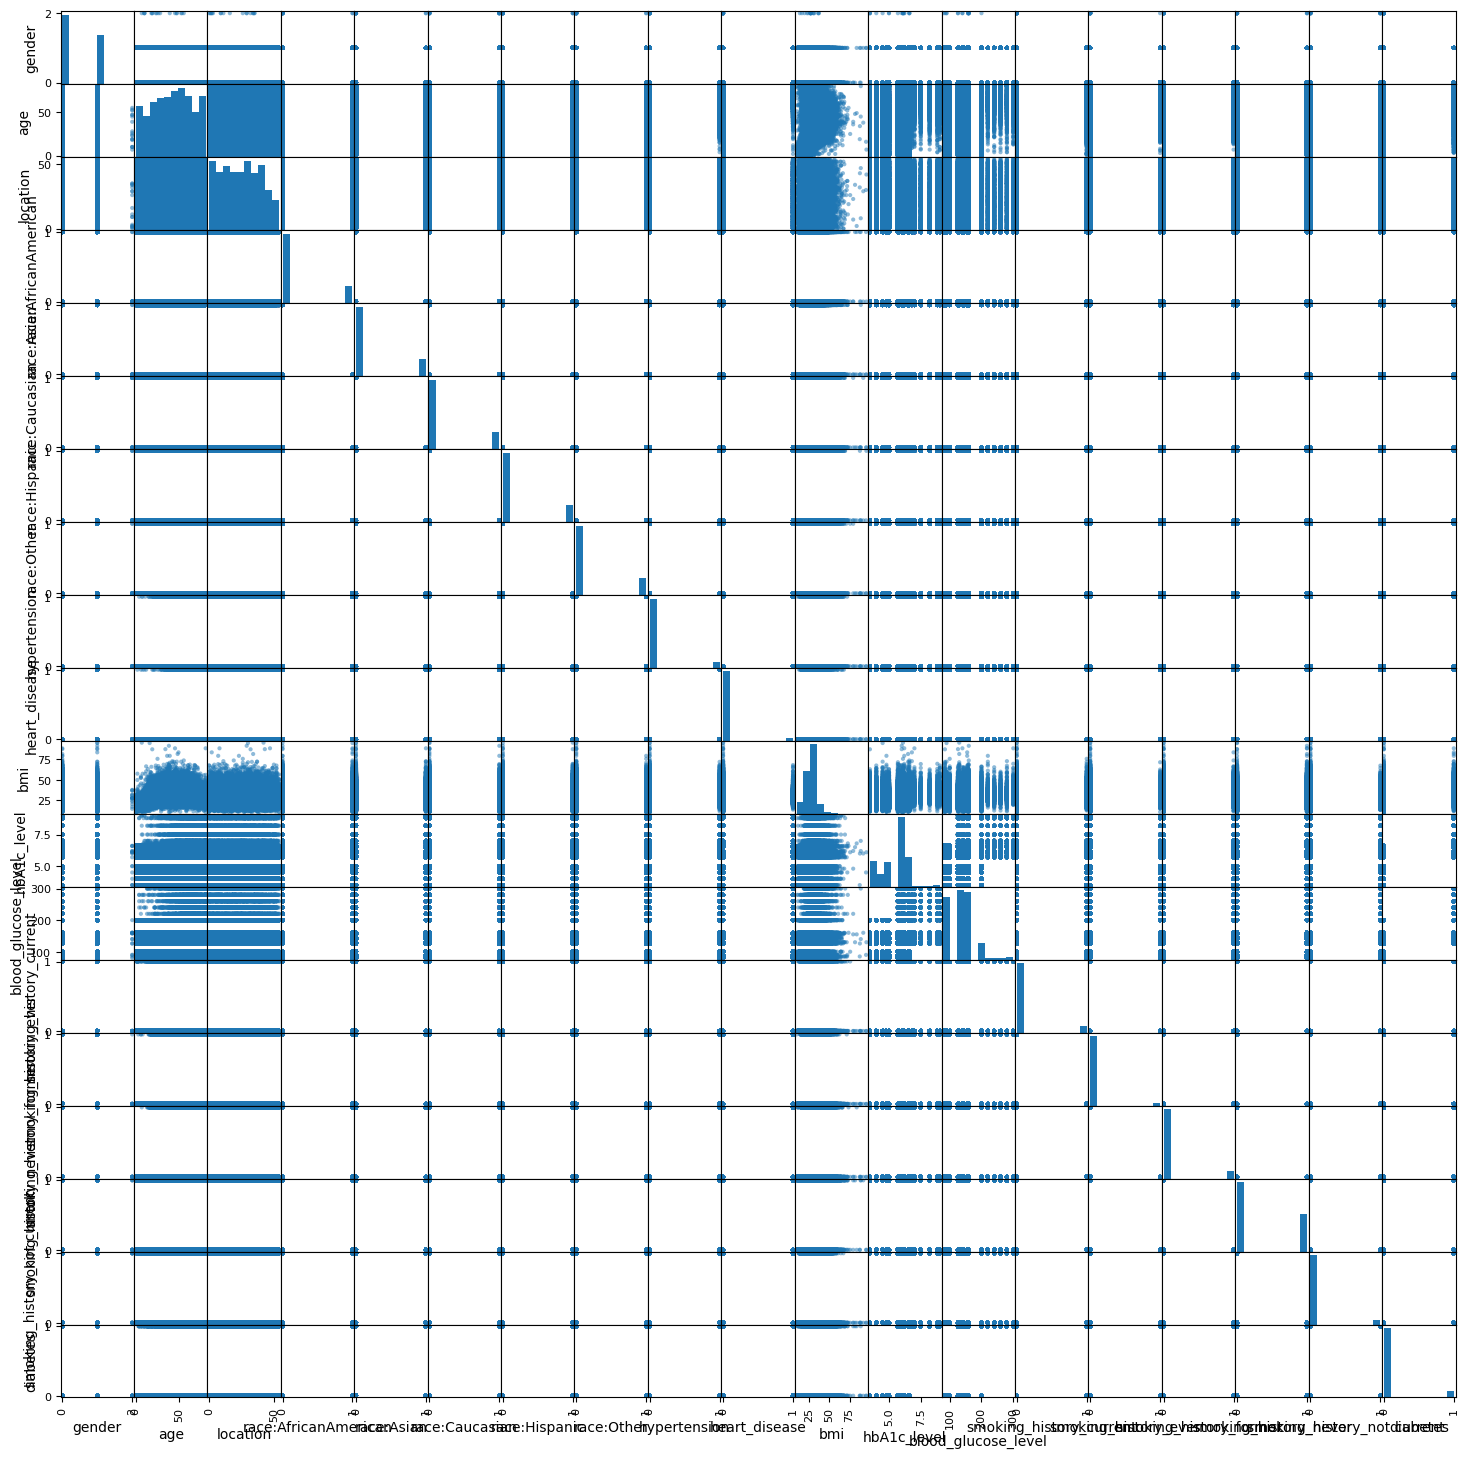

In [169]:
pd.plotting.scatter_matrix(df, figsize=(18,18))
plt.show()

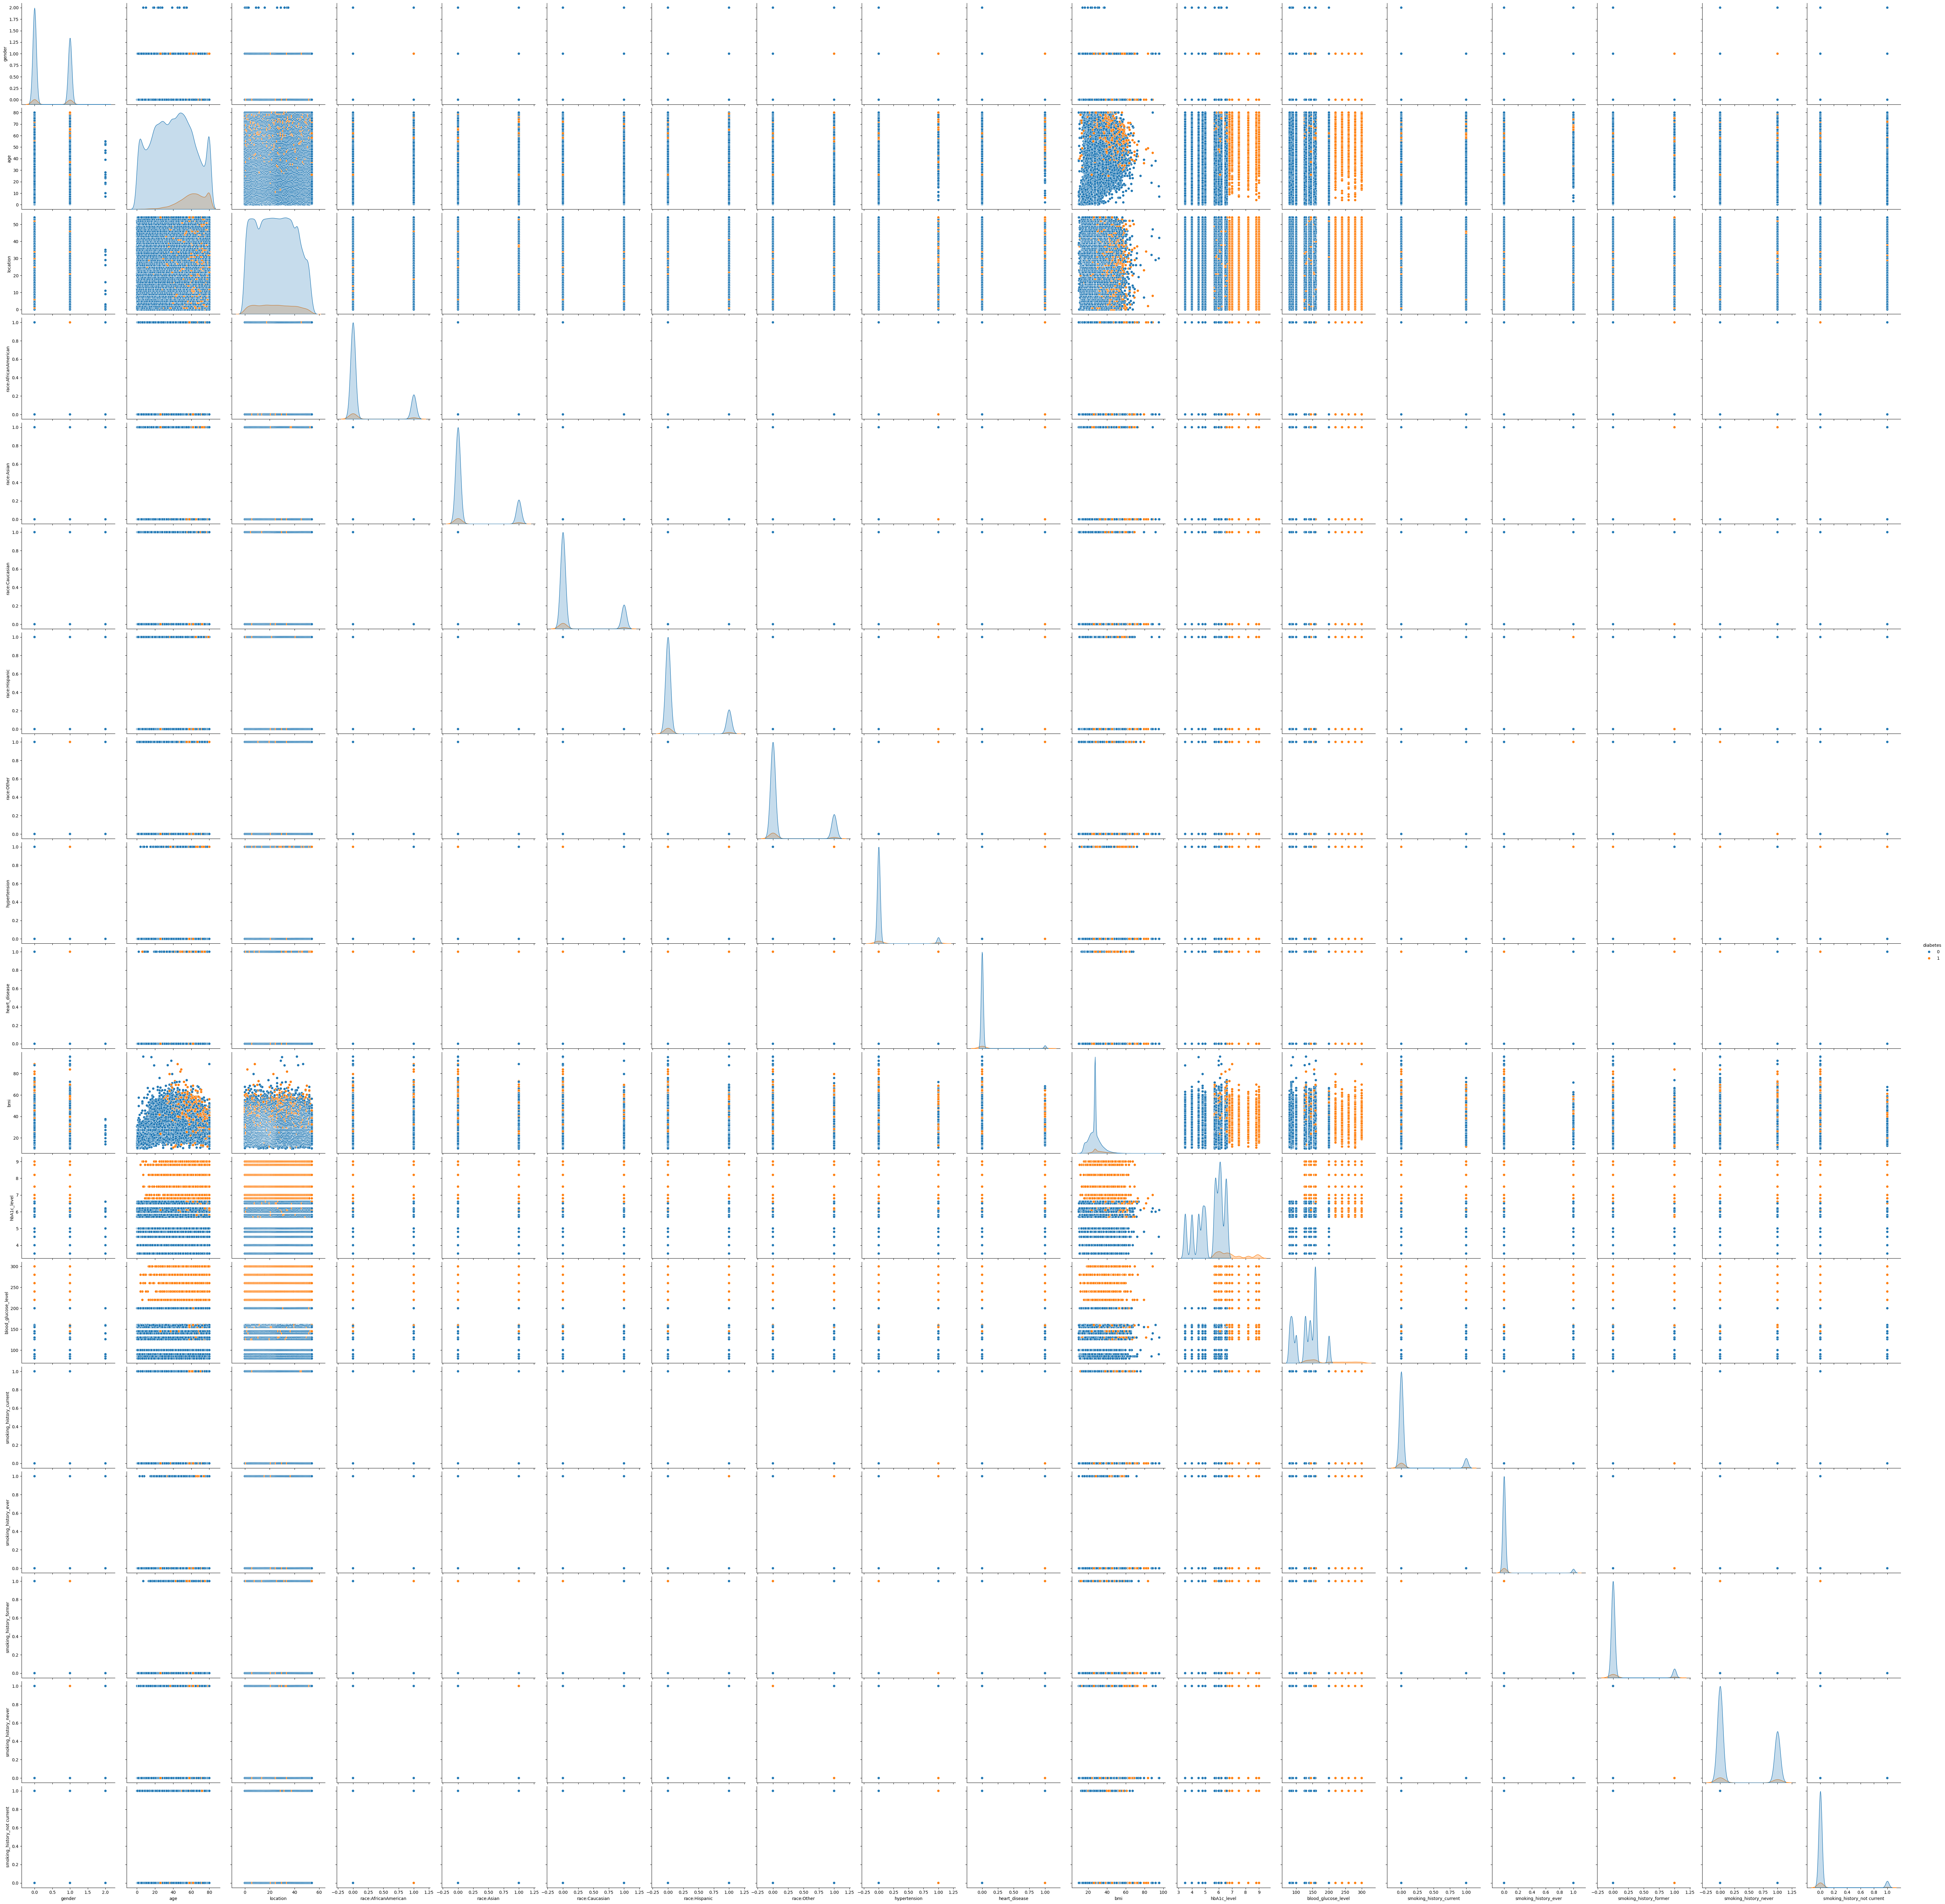

In [170]:
# matriz de gráficos scatter
sns.pairplot(df, hue='diabetes', height=3.5);

# mostra o gráfico usando a função show() da matplotlib
plt.show() 


## Pré-processamento: detecção de *outliers*

In [171]:
continuous_cols = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']

def removeOutliers(df):
  """
  Remove os outliers da base de dados, considerando os atributos contínuos definidos anteriormente
  """

  for atributo in continuous_cols:
    # Obtem o terceiro e o primeiro quartil.
    q75, q25 = np.percentile(df[atributo].values, [75 ,25])
    # Calcula o IQR
    IQR = q75 - q25
    # Remove os outliers com base no valor do IQR
    df = df[ (df[atributo]<=(q75+1.5*IQR)) & (df[atributo]>=(q25-1.5*IQR)) ]

  return df

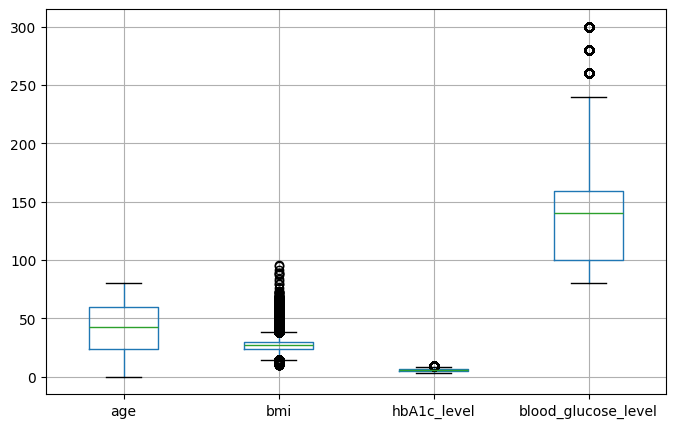

In [172]:
# Gera um bloxplot para cada atributo numérico contínuo
df.boxplot(figsize=(8,5), column=continuous_cols)
plt.show()

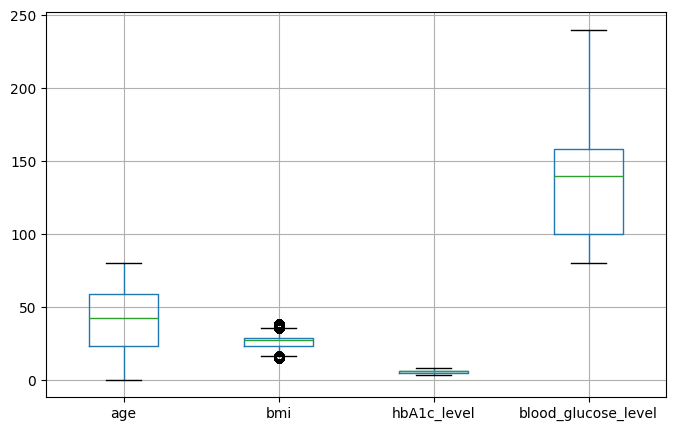

In [173]:
df = removeOutliers(df) # Remove os outliers

# Gera um bloxplot para numérico contínuo
df.boxplot(figsize=(8,5), column=continuous_cols)
plt.show()

In [174]:
# Exibe as caracteristicas da base de dados após a remoção dos outliers
df.describe()

gender           age      location  race:AfricanAmerican  \
count  90365.000000  90365.000000  90365.000000          90365.000000   
mean       0.418945     41.407037     24.759708              0.202025   
std        0.493770     22.557965     14.775862              0.401513   
min        0.000000      0.080000      0.000000              0.000000   
25%        0.000000     23.000000     12.000000              0.000000   
50%        0.000000     42.000000     25.000000              0.000000   
75%        1.000000     59.000000     37.000000              0.000000   
max        2.000000     80.000000     54.000000              1.000000   

         race:Asian  race:Caucasian  race:Hispanic    race:Other  \
count  90365.000000    90365.000000   90365.000000  90365.000000   
mean       0.200310        0.199070       0.198860      0.199734   
std        0.400234        0.399303       0.399145      0.399803   
min        0.000000        0.000000       0.000000      0.000000   
25%        0.000000        0.000000       0.000000      0.000000   
50%        0.000000        0.000000       0.000000      0.000000   
75%        0.000000        0.000000       0.000000      0.000000   
max        1.000000        1.000000       1.000000      1.000000   

       hypertension  heart_disease           bmi   hbA1c_level  \
count  90365.000000   90365.000000  90365.000000  90365.000000   
mean       0.065667       0.035633     26.317441      5.456327   
std        0.247701       0.185375      4.879449      0.994863   
min        0.000000       0.000000     14.710000      3.500000   
25%        0.000000       0.000000     23.370000      4.800000   
50%        0.000000       0.000000     27.320000      5.800000   
75%        0.000000       0.000000     28.290000      6.200000   
max        1.000000       1.000000     38.500000      8.200000   

       blood_glucose_level  smoking_history_current  smoking_history_ever  \
count         90365.000000             90365.000000          90365.000000   
mean            134.574005                 0.092027              0.039197   
std              35.198240                 0.289065              0.194063   
min              80.000000                 0.000000              0.000000   
25%             100.000000                 0.000000              0.000000   
50%             140.000000                 0.000000              0.000000   
75%             158.000000                 0.000000              0.000000   
max             240.000000                 1.000000              1.000000   

       smoking_history_former  smoking_history_never  \
count            90365.000000           90365.000000   
mean                 0.089249               0.347867   
std                  0.285105               0.476296   
min                  0.000000               0.000000   
25%                  0.000000               0.000000   
50%                  0.000000               0.000000   
75%                  0.000000               1.000000   
max                  1.000000               1.000000   

       smoking_history_not current      diabetes  
count                 90365.000000  90365.000000  
mean                      0.063775      0.049732  
std                       0.244352      0.217391  
min                       0.000000      0.000000  
25%                       0.000000      0.000000  
50%                       0.000000      0.000000  
75%                       0.000000      0.000000  
max                       1.000000      1.000000

Aplicando o mesmo tratamento ao dataset sem o atributo 'location'.

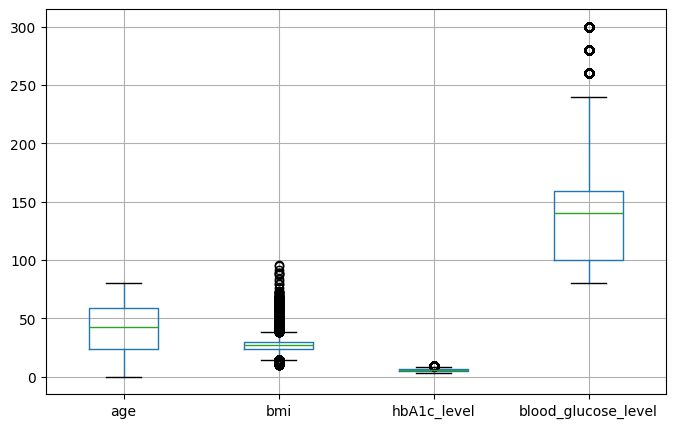

In [175]:
# Gera um bloxplot para cada atributo numérico contínuo
df_without_location.boxplot(figsize=(8,5), column=continuous_cols)
plt.show()

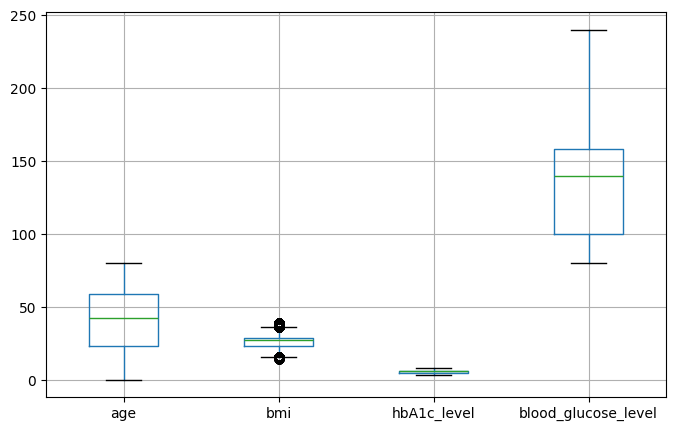

In [176]:
df_without_location = removeOutliers(df_without_location) # Remove os outliers

# Gera um bloxplot para numérico contínuo
df_without_location.boxplot(figsize=(8,5), column=continuous_cols)
plt.show()

In [177]:
# Exibe as caracteristicas da base de dados após a remoção dos outliers
df_without_location.describe()

gender           age  race:AfricanAmerican    race:Asian  \
count  89881.000000  89881.000000          89881.000000  89881.000000   
mean       0.419499     41.267297              0.201911      0.200365   
std        0.493863     22.556181              0.401429      0.400276   
min        0.000000      0.080000              0.000000      0.000000   
25%        0.000000     23.000000              0.000000      0.000000   
50%        0.000000     42.000000              0.000000      0.000000   
75%        1.000000     59.000000              0.000000      0.000000   
max        2.000000     80.000000              1.000000      1.000000   

       race:Caucasian  race:Hispanic    race:Other  hypertension  \
count    89881.000000   89881.000000  89881.000000  89881.000000   
mean         0.199163       0.198874      0.199686      0.066243   
std          0.399373       0.399155      0.399767      0.248708   
min          0.000000       0.000000      0.000000      0.000000   
25%          0.000000       0.000000      0.000000      0.000000   
50%          0.000000       0.000000      0.000000      0.000000   
75%          0.000000       0.000000      0.000000      0.000000   
max          1.000000       1.000000      1.000000      1.000000   

       heart_disease           bmi   hbA1c_level  blood_glucose_level  \
count   89881.000000  89881.000000  89881.000000         89881.000000   
mean        0.035948     26.307922      5.456754           134.576840   
std         0.186160      4.963825      0.994921            35.219297   
min         0.000000     14.490000      3.500000            80.000000   
25%         0.000000     23.280000      4.800000           100.000000   
50%         0.000000     27.320000      5.800000           140.000000   
75%         0.000000     28.360000      6.200000           158.000000   
max         1.000000     38.730000      8.200000           240.000000   

       smoking_history_current  smoking_history_ever  smoking_history_former  \
count             89881.000000          89881.000000            89881.000000   
mean                  0.092622              0.039463                0.089897   
std                   0.289904              0.194696                0.286035   
min                   0.000000              0.000000                0.000000   
25%                   0.000000              0.000000                0.000000   
50%                   0.000000              0.000000                0.000000   
75%                   0.000000              0.000000                0.000000   
max                   1.000000              1.000000                1.000000   

       smoking_history_never  smoking_history_not current      diabetes  
count           89881.000000                 89881.000000  89881.000000  
mean                0.349451                     0.064174      0.050055  
std                 0.476799                     0.245064      0.218060  
min                 0.000000                     0.000000      0.000000  
25%                 0.000000                     0.000000      0.000000  
50%                 0.000000                     0.000000      0.000000  
75%                 1.000000                     0.000000      0.000000  
max                 1.000000                     1.000000      1.000000

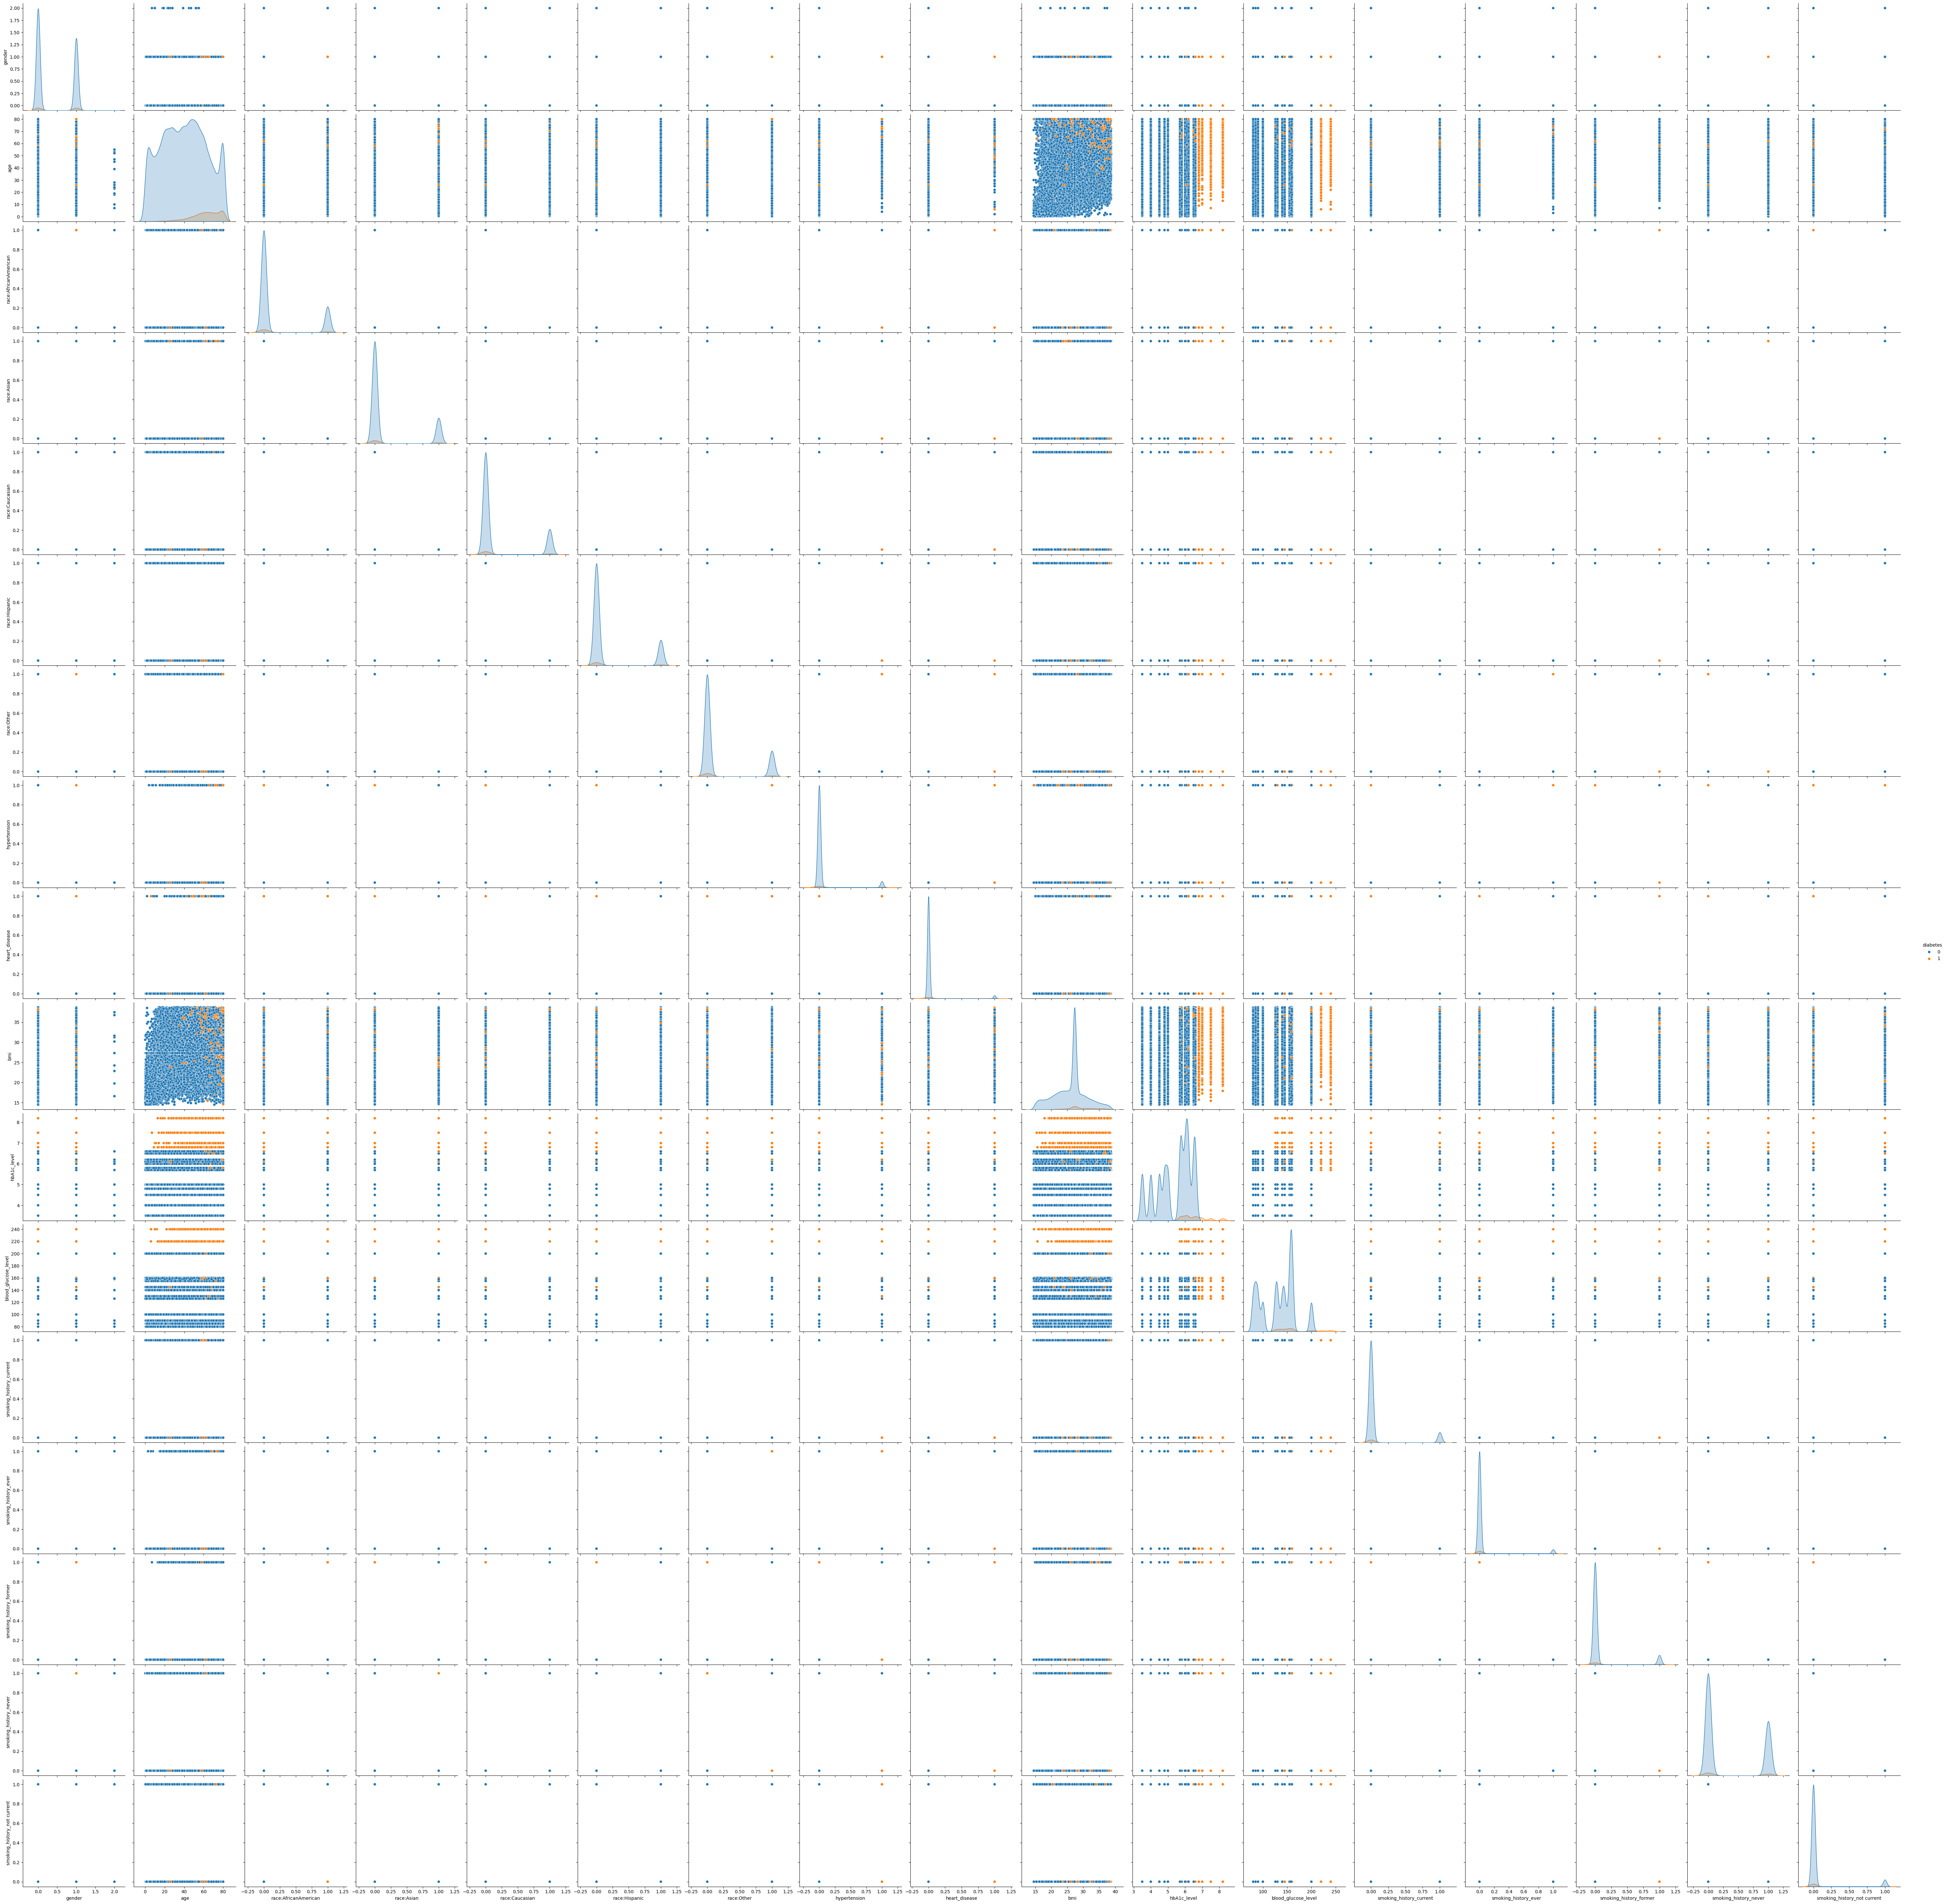

In [ ]:
# matriz de gráficos scatter após a remoção de 'location' e outliers

sns.pairplot(df_without_location, hue='diabetes', height=3.5);

# mostra o gráfico usando a função show() da matplotlib
plt.show()

## Pré-processamento: normalização dos atributos

In [179]:
def normalizar(X):
  """
  Normaliza os atributos em X

  Esta função retorna uma versao normalizada de X onde o valor da
  média de cada atributo é igual a 0 e desvio padrao é igual a 1. Trata-se de
  um importante passo de pré-processamento quando trabalha-se com
  métodos de aprendizado de máquina.
  """

  m, n = X.shape # m = qtde de objetos e n = qtde de atributos por objeto

  # Incializa as variaves de saída
  X_norm = np.zeros((m, n))  # Inicializa X_norm com zeros
  mu = 0 # Inicializa a média
  sigma = 1 # Inicializa o desvio padrão

  mu = np.mean(X, axis=0)
  sigma = np.std(X, axis=0, ddof=1)

  for i in range(m):
    X_norm[i, :] = (X[i, :] - mu) / sigma

  return X_norm, mu, sigma

Realiza uma cópia dos datasets antes de normalizar os dados, para ser usado posteriormente para normalizar os dados de teste.

In [180]:
df_copy = df.copy()
df_without_location_copy = df_without_location.copy()

In [181]:
X = df[continuous_cols].values # Extrai valores das colunas contínuas para normalização
X_norm, mu, sigma = normalizar(X) # Normaliza apenas as colunas contínuas
df[continuous_cols] = X_norm # Atualiza as colunas contínuas no DataFrame original com os valores normalizados

print('Primeira amostra da base antes da normalização: [%2.4f %2.4f].' %(X[0,0],X[0,1]))
print('Primeira amostra da base após normalização: [%2.4f %2.4f].' %(X_norm[0,0],X_norm[0,1]))

display(df.head())

# Apresenta as principais estatísticas da base de dados
df.describe().round(4)

Primeira amostra da base antes da normalização: [32.0000 27.3200].
Primeira amostra da base após normalização: [-0.4170 0.2055].


gender       age  location  race:AfricanAmerican  race:Asian  \
0       0 -0.417016         0                     0           0   
1       0 -0.550007         0                     0           1   
2       1 -1.037640         0                     0           0   
3       1 -0.018044         0                     0           0   
4       0  0.469589         0                     1           0   

   race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
0               0              0           1             0              0   
1               0              0           0             0              0   
2               0              0           1             0              0   
3               1              0           0             0              0   
4               0              0           0             0              0   

        bmi  hbA1c_level  blood_glucose_level  smoking_history_current  \
0  0.205466    -0.458683            -0.982265                        0   
1 -1.304951    -0.458683            -1.266370                        0   
2 -0.524125    -0.659716             0.722366                        0   
3  0.205466    -1.463846             0.693955                        0   
4 -0.526174     1.049062            -1.266370                        0   

   smoking_history_ever  smoking_history_former  smoking_history_never  \
0                     0                       0                      1   
1                     0                       0                      1   
2                     0                       0                      1   
3                     0                       0                      1   
4                     0                       0                      1   

   smoking_history_not current  diabetes  
0                            0         0  
1                            0         0  
2                            0         0  
3                            0         0  
4                            0         0

gender         age    location  race:AfricanAmerican  race:Asian  \
count  90365.0000  90365.0000  90365.0000            90365.0000  90365.0000   
mean       0.4189      0.0000     24.7597                0.2020      0.2003   
std        0.4938      1.0000     14.7759                0.4015      0.4002   
min        0.0000     -1.8320      0.0000                0.0000      0.0000   
25%        0.0000     -0.8160     12.0000                0.0000      0.0000   
50%        0.0000      0.0263     25.0000                0.0000      0.0000   
75%        1.0000      0.7799     37.0000                0.0000      0.0000   
max        2.0000      1.7108     54.0000                1.0000      1.0000   

       race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
count      90365.0000     90365.0000  90365.0000    90365.0000     90365.0000   
mean           0.1991         0.1989      0.1997        0.0657         0.0356   
std            0.3993         0.3991      0.3998        0.2477         0.1854   
min            0.0000         0.0000      0.0000        0.0000         0.0000   
25%            0.0000         0.0000      0.0000        0.0000         0.0000   
50%            0.0000         0.0000      0.0000        0.0000         0.0000   
75%            0.0000         0.0000      0.0000        0.0000         0.0000   
max            1.0000         1.0000      1.0000        1.0000         1.0000   

              bmi  hbA1c_level  blood_glucose_level  smoking_history_current  \
count  90365.0000   90365.0000           90365.0000               90365.0000   
mean       0.0000       0.0000               0.0000                   0.0920   
std        1.0000       1.0000               1.0000                   0.2891   
min       -2.3788      -1.9664              -1.5505                   0.0000   
25%       -0.6041      -0.6597              -0.9823                   0.0000   
50%        0.2055       0.3454               0.1542                   0.0000   
75%        0.4043       0.7475               0.6655                   0.0000   
max        2.4967       2.7578               2.9952                   1.0000   

       smoking_history_ever  smoking_history_former  smoking_history_never  \
count            90365.0000              90365.0000             90365.0000   
mean                 0.0392                  0.0892                 0.3479   
std                  0.1941                  0.2851                 0.4763   
min                  0.0000                  0.0000                 0.0000   
25%                  0.0000                  0.0000                 0.0000   
50%                  0.0000                  0.0000                 0.0000   
75%                  0.0000                  0.0000                 1.0000   
max                  1.0000                  1.0000                 1.0000   

       smoking_history_not current    diabetes  
count                   90365.0000  90365.0000  
mean                        0.0638      0.0497  
std                         0.2444      0.2174  
min                         0.0000      0.0000  
25%                         0.0000      0.0000  
50%                         0.0000      0.0000  
75%                         0.0000      0.0000  
max                         1.0000      1.0000

Aplicando a mesma normalização ao dataset sem o atributo 'location'.

In [182]:
X = df_without_location[continuous_cols].values # Extrai valores das colunas contínuas para normalização
X_norm, mu, sigma = normalizar(X) # Normaliza apenas as colunas contínuas
df_without_location[continuous_cols] = X_norm # Atualiza as colunas contínuas no DataFrame original com os valores normalizados

print('Primeira amostra da base antes da normalização: [%2.4f %2.4f].' %(X[0,0],X[0,1]))
print('Primeira amostra da base após normalização: [%2.4f %2.4f].' %(X_norm[0,0],X_norm[0,1]))

display(df_without_location.head())

# Apresenta as principais estatísticas da base de dados
df_without_location.describe().round(4)

Primeira amostra da base antes da normalização: [32.0000 27.3200].
Primeira amostra da base após normalização: [-0.4109 0.2039].


gender       age  race:AfricanAmerican  race:Asian  race:Caucasian  \
0       0 -0.410854                     0           0               0   
1       0 -0.543855                     0           1               0   
2       1 -1.031526                     0           0               0   
3       1 -0.011850                     0           0               1   
4       0  0.475821                     1           0               0   

   race:Hispanic  race:Other  hypertension  heart_disease       bmi  \
0              0           1             0              0  0.203891   
1              0           0             0              0 -1.280851   
2              0           1             0              0 -0.513298   
3              0           0             0              0  0.203891   
4              0           0             0              0 -0.515313   

   hbA1c_level  blood_glucose_level  smoking_history_current  \
0    -0.459086            -0.981758                        0   
1    -0.459086            -1.265694                        0   
2    -0.660107             0.721853                        0   
3    -1.464191             0.693460                        0   
4     1.048572            -1.265694                        0   

   smoking_history_ever  smoking_history_former  smoking_history_never  \
0                     0                       0                      1   
1                     0                       0                      1   
2                     0                       0                      1   
3                     0                       0                      1   
4                     0                       0                      1   

   smoking_history_not current  diabetes  
0                            0         0  
1                            0         0  
2                            0         0  
3                            0         0  
4                            0         0

gender         age  race:AfricanAmerican  race:Asian  \
count  89881.0000  89881.0000            89881.0000  89881.0000   
mean       0.4195      0.0000                0.2019      0.2004   
std        0.4939      1.0000                0.4014      0.4003   
min        0.0000     -1.8260                0.0000      0.0000   
25%        0.0000     -0.8099                0.0000      0.0000   
50%        0.0000      0.0325                0.0000      0.0000   
75%        1.0000      0.7862                0.0000      0.0000   
max        2.0000      1.7172                1.0000      1.0000   

       race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
count      89881.0000     89881.0000  89881.0000    89881.0000     89881.0000   
mean           0.1992         0.1989      0.1997        0.0662         0.0359   
std            0.3994         0.3992      0.3998        0.2487         0.1862   
min            0.0000         0.0000      0.0000        0.0000         0.0000   
25%            0.0000         0.0000      0.0000        0.0000         0.0000   
50%            0.0000         0.0000      0.0000        0.0000         0.0000   
75%            0.0000         0.0000      0.0000        0.0000         0.0000   
max            1.0000         1.0000      1.0000        1.0000         1.0000   

              bmi  hbA1c_level  blood_glucose_level  smoking_history_current  \
count  89881.0000   89881.0000           89881.0000               89881.0000   
mean       0.0000      -0.0000               0.0000                   0.0926   
std        1.0000       1.0000               1.0000                   0.2899   
min       -2.3808      -1.9667              -1.5496                   0.0000   
25%       -0.6100      -0.6601              -0.9818                   0.0000   
50%        0.2039       0.3450               0.1540                   0.0000   
75%        0.4134       0.7470               0.6651                   0.0000   
max        2.5025       2.7573               2.9933                   1.0000   

       smoking_history_ever  smoking_history_former  smoking_history_never  \
count            89881.0000              89881.0000             89881.0000   
mean                 0.0395                  0.0899                 0.3495   
std                  0.1947                  0.2860                 0.4768   
min                  0.0000                  0.0000                 0.0000   
25%                  0.0000                  0.0000                 0.0000   
50%                  0.0000                  0.0000                 0.0000   
75%                  0.0000                  0.0000                 1.0000   
max                  1.0000                  1.0000                 1.0000   

       smoking_history_not current    diabetes  
count                   89881.0000  89881.0000  
mean                        0.0642      0.0501  
std                         0.2451      0.2181  
min                         0.0000      0.0000  
25%                         0.0000      0.0000  
50%                         0.0000      0.0000  
75%                         0.0000      0.0000  
max                         1.0000      1.0000

## Pré-processamento: distribuição das classes

diabetes
0    85871
1     4494
Name: count, dtype: int64

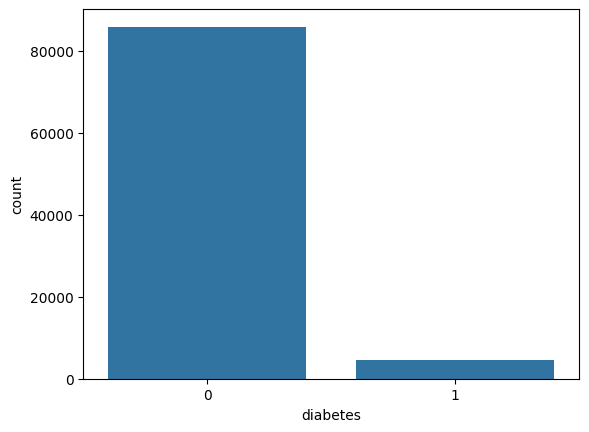

In [183]:
display(df['diabetes'].value_counts())

# Cria um gráfico de barras com a frequência de cada classe
sns.countplot(x='diabetes', data=df)
plt.show()

diabetes
0    85382
1     4499
Name: count, dtype: int64

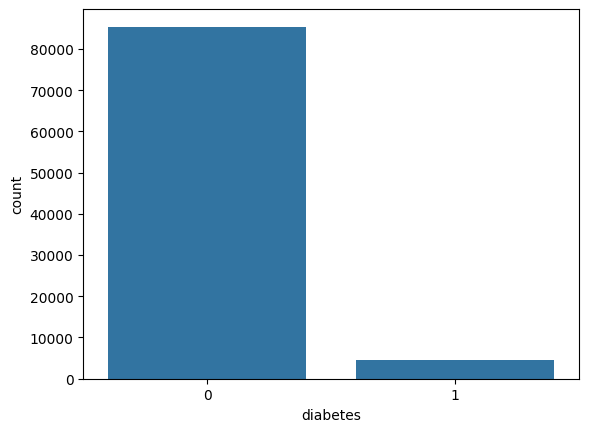

In [184]:
display(df_without_location['diabetes'].value_counts())

# Cria um gráfico de barras com a frequência de cada classe
sns.countplot(x='diabetes', data=df_without_location)
plt.show()

## Pré-processamento: correlação entre os atributos

In [185]:
# Filtra apenas as colunas numéricas
df_values = df.drop(columns=['diabetes']).select_dtypes(include=[np.number])

# Matriz de correlação
df_correlation = df_values.corr()

print('Matriz de correlação: ')
display(df_correlation)

Matriz de correlação: 


gender       age  location  \
gender                       1.000000 -0.032971 -0.001361   
age                         -0.032971  1.000000  0.005421   
location                    -0.001361  0.005421  1.000000   
race:AfricanAmerican         0.001436 -0.002122 -0.002118   
race:Asian                  -0.000634  0.003149 -0.000319   
race:Caucasian              -0.005580  0.004257 -0.001164   
race:Hispanic                0.003512  0.000922  0.004385   
race:Other                   0.001259 -0.006193 -0.000770   
hypertension                 0.016556  0.248926  0.005905   
heart_disease                0.078222  0.229183  0.006932   
bmi                          0.021200  0.387953  0.001283   
hbA1c_level                  0.014394  0.051043  0.003191   
blood_glucose_level          0.008813  0.047248  0.005874   
smoking_history_current      0.025822  0.032930 -0.004945   
smoking_history_ever         0.009250  0.065974  0.002690   
smoking_history_former       0.046632  0.215308 -0.001821   
smoking_history_never       -0.096723  0.057942  0.000400   
smoking_history_not current -0.009574  0.068362  0.005100   

                             race:AfricanAmerican  race:Asian  race:Caucasian  \
gender                                   0.001436   -0.000634       -0.005580   
age                                     -0.002122    0.003149        0.004257   
location                                -0.002118   -0.000319       -0.001164   
race:AfricanAmerican                     1.000000   -0.251825       -0.250850   
race:Asian                              -0.251825    1.000000       -0.249515   
race:Caucasian                          -0.250850   -0.249515        1.000000   
race:Hispanic                           -0.250685   -0.249350       -0.248385   
race:Other                              -0.251372   -0.250034       -0.249067   
hypertension                            -0.000091    0.000822        0.000416   
heart_disease                           -0.001564    0.005072       -0.000001   
bmi                                     -0.000324    0.006200       -0.002425   
hbA1c_level                              0.000241   -0.001272       -0.001771   
blood_glucose_level                      0.004604   -0.001553        0.004001   
smoking_history_current                 -0.004295   -0.007440        0.004365   
smoking_history_ever                     0.001339    0.000214        0.002270   
smoking_history_former                   0.001805    0.000146       -0.002868   
smoking_history_never                    0.004186   -0.001262        0.000944   
smoking_history_not current              0.002113   -0.000044        0.003375   

                             race:Hispanic  race:Other  hypertension  \
gender                            0.003512    0.001259      0.016556   
age                               0.000922   -0.006193      0.248926   
location                          0.004385   -0.000770      0.005905   
race:AfricanAmerican             -0.250685   -0.251372     -0.000091   
race:Asian                       -0.249350   -0.250034      0.000822   
race:Caucasian                   -0.248385   -0.249067      0.000416   
race:Hispanic                     1.000000   -0.248902      0.004697   
race:Other                       -0.248902    1.000000     -0.005836   
hypertension                      0.004697   -0.005836      1.000000   
heart_disease                    -0.000199   -0.003307      0.122323   
bmi                              -0.000028   -0.003432      0.130200   
hbA1c_level                       0.001881    0.000922      0.042296   
blood_glucose_level               0.000305   -0.007369      0.037554   
smoking_history_current           0.008467   -0.001052      0.020697   
smoking_history_ever             -0.000766   -0.003061      0.024497   
smoking_history_former           -0.000759    0.001664      0.081390   
smoking_history_never            -0.004841    0.000950      0.040030   
smoking_history_not current      -0

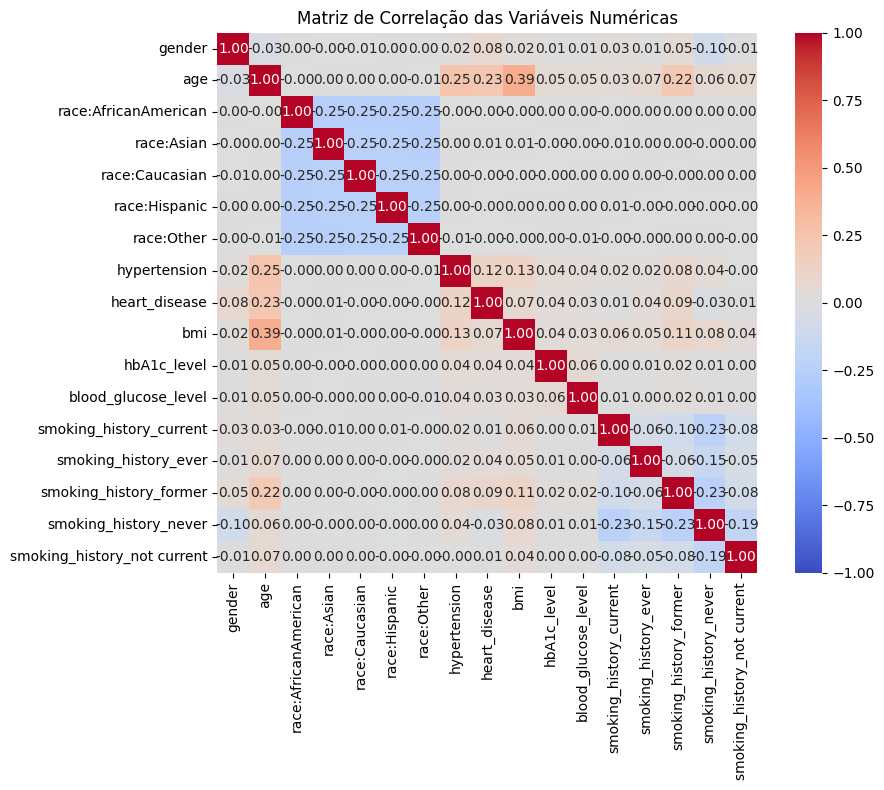

Matriz de correlação (sem o atributo "location"): 


gender       age  race:AfricanAmerican  \
gender                       1.000000 -0.032530              0.001231   
age                         -0.032530  1.000000             -0.002088   
race:AfricanAmerican         0.001231 -0.002088              1.000000   
race:Asian                  -0.000774  0.002594             -0.251779   
race:Caucasian              -0.005723  0.004475             -0.250835   
race:Hispanic                0.003525  0.001843             -0.250607   
race:Other                   0.001737 -0.006811             -0.251246   
hypertension                 0.015879  0.251390             -0.000020   
heart_disease                0.078128  0.231242             -0.001694   
bmi                          0.019474  0.393360             -0.000504   
hbA1c_level                  0.014261  0.051628              0.000405   
blood_glucose_level          0.008715  0.047786              0.003822   
smoking_history_current      0.025152  0.034948             -0.004581   
smoking_history_ever         0.009145  0.067458              0.001540   
smoking_history_former       0.046583  0.217799              0.001701   
smoking_history_never       -0.097383  0.061863              0.003904   
smoking_history_not current -0.009990  0.069515              0.002191   

                             race:Asian  race:Caucasian  race:Hispanic  \
gender                        -0.000774       -0.005723       0.003525   
age                            0.002594        0.004475       0.001843   
race:AfricanAmerican          -0.251779       -0.250835      -0.250607   
race:Asian                     1.000000       -0.249631      -0.249404   
race:Caucasian                -0.249631        1.000000      -0.248469   
race:Hispanic                 -0.249404       -0.248469       1.000000   
race:Other                    -0.250040       -0.249102      -0.248876   
hypertension                   0.001232        0.000020       0.004584   
heart_disease                  0.005020       -0.000074      -0.000234   
bmi                            0.006830       -0.003041       0.000404   
hbA1c_level                   -0.001014       -0.001869       0.002032   
blood_glucose_level           -0.000991        0.004957       0.000122   
smoking_history_current       -0.007674        0.004033       0.008978   
smoking_history_ever           0.000186        0.002084      -0.000774   
smoking_history_former         0.000394       -0.002653      -0.000965   
smoking_history_never         -0.001181        0.001255      -0.004702   
smoking_history_not current    0.000260        0.003322      -0.003993   

                             race:Other  hypertension  heart_disease  \
gender                         0.001737      0.015879       0.078128   
age                           -0.006811      0.251390       0.231242   
race:AfricanAmerican          -0.251246     -0.000020      -0.001694   
race:Asian                    -0.250040      0.001232       0.005020   
race:Caucasian                -0.249102      0.000020      -0.000074   
race:Hispanic                 -0.248876      0.004584      -0.000234   
race:Other                     1.000000     -0.005811      -0.003018   
hypertension                  -0.005811      1.000000       0.122307   
heart_disease                 -0.003018      0.122307       1.000000   
bmi                           -0.003697      0.131158       0.067443   
hbA1c_level                    0.000447      0.042894       0.036308   
blood_glucose_level           -0.007920      0.038201       0.028343   
smoking_history_current       -0.000709      0.020296       0.005306   
smoking_history_ever          -0.003043      0.023904       0.037602   
smoking_history_former         0.001512      0.080975       0.092467   
smoking_history_never          0.000704      0.040097      -0.031221   
smoking_history_not current   -0.001793     -0.002390       0.006744   

                                  bmi  hbA1c_level  blood_glucose_level  \
gender     

In [186]:
# Filtra apenas as colunas numéricas
df_values = df_without_location.drop(columns=['diabetes']).select_dtypes(include=[np.number])

# Matriz de correlação
df_correlation = df_values.corr()

    # Cria um heatmap da matriz de correlação
def plot_correlation_matrix(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_correlation, 
            annot=True,        # Mostra os valores
            cmap='coolwarm',   # Esquema de cores
            vmin=-1, vmax=1,   # Limites dos valores
            center=0,          # Centro da escala de cores
            fmt='.2f',         # Formato dos números
            square=True)       # Células quadradas
    
    plt.title('Matriz de Correlação das Variáveis Numéricas')
    plt.tight_layout()
    plt.show()
    
    return df_correlation

# Calcula e mostra a matriz de correlação
df_correlation = plot_correlation_matrix(df)

print('Matriz de correlação (sem o atributo "location"): ')
display(df_correlation)

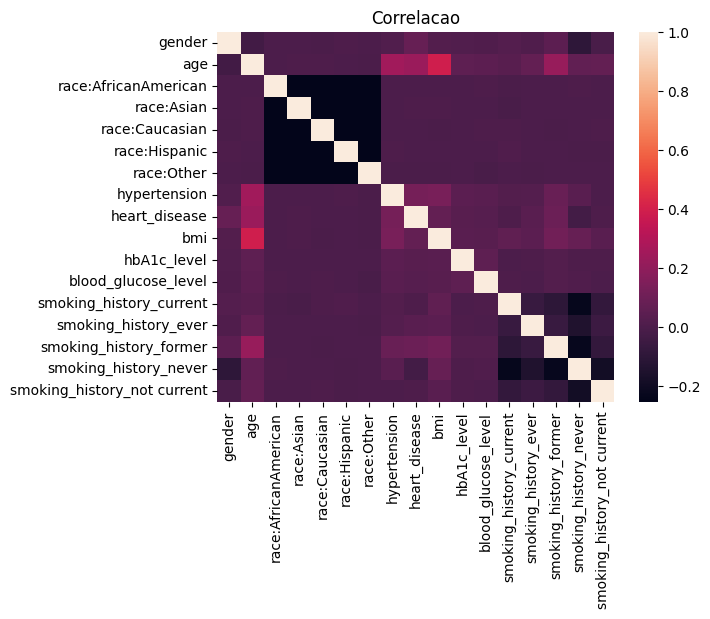

In [187]:
# cria um mapa de cores dos valores da correlação
sns.heatmap(df_correlation,
        xticklabels=df_correlation.columns,
        yticklabels=df_correlation.columns)

plt.title('Correlacao')
plt.show()

# Pós processamento

## Informações

In [188]:
print(f'Dimensão do DF: {df.shape}')
display(df.head())
display(df.describe()) # Resumo estatístico
df.groupby('diabetes').size() # Distribuição de classe

Dimensão do DF: (90365, 19)


gender       age  location  race:AfricanAmerican  race:Asian  \
0       0 -0.417016         0                     0           0   
1       0 -0.550007         0                     0           1   
2       1 -1.037640         0                     0           0   
3       1 -0.018044         0                     0           0   
4       0  0.469589         0                     1           0   

   race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
0               0              0           1             0              0   
1               0              0           0             0              0   
2               0              0           1             0              0   
3               1              0           0             0              0   
4               0              0           0             0              0   

        bmi  hbA1c_level  blood_glucose_level  smoking_history_current  \
0  0.205466    -0.458683            -0.982265                        0   
1 -1.304951    -0.458683            -1.266370                        0   
2 -0.524125    -0.659716             0.722366                        0   
3  0.205466    -1.463846             0.693955                        0   
4 -0.526174     1.049062            -1.266370                        0   

   smoking_history_ever  smoking_history_former  smoking_history_never  \
0                     0                       0                      1   
1                     0                       0                      1   
2                     0                       0                      1   
3                     0                       0                      1   
4                     0                       0                      1   

   smoking_history_not current  diabetes  
0                            0         0  
1                            0         0  
2                            0         0  
3                            0         0  
4                            0         0

gender           age      location  race:AfricanAmerican  \
count  90365.000000  9.036500e+04  90365.000000          90365.000000   
mean       0.418945  3.532172e-16     24.759708              0.202025   
std        0.493770  1.000000e+00     14.775862              0.401513   
min        0.000000 -1.832037e+00      0.000000              0.000000   
25%        0.000000 -8.159884e-01     12.000000              0.000000   
50%        0.000000  2.628618e-02     25.000000              0.000000   
75%        1.000000  7.799003e-01     37.000000              0.000000   
max        2.000000  1.710835e+00     54.000000              1.000000   

         race:Asian  race:Caucasian  race:Hispanic    race:Other  \
count  90365.000000    90365.000000   90365.000000  90365.000000   
mean       0.200310        0.199070       0.198860      0.199734   
std        0.400234        0.399303       0.399145      0.399803   
min        0.000000        0.000000       0.000000      0.000000   
25%        0.000000        0.000000       0.000000      0.000000   
50%        0.000000        0.000000       0.000000      0.000000   
75%        0.000000        0.000000       0.000000      0.000000   
max        1.000000        1.000000       1.000000      1.000000   

       hypertension  heart_disease           bmi   hbA1c_level  \
count  90365.000000   90365.000000  9.036500e+04  9.036500e+04   
mean       0.065667       0.035633  1.164908e-15  3.979873e-16   
std        0.247701       0.185375  1.000000e+00  1.000000e+00   
min        0.000000       0.000000 -2.378843e+00 -1.966428e+00   
25%        0.000000       0.000000 -6.040521e-01 -6.597158e-01   
50%        0.000000       0.000000  2.054655e-01  3.454473e-01   
75%        0.000000       0.000000  4.042585e-01  7.475126e-01   
max        1.000000       1.000000  2.496708e+00  2.757839e+00   

       blood_glucose_level  smoking_history_current  smoking_history_ever  \
count         9.036500e+04             90365.000000          90365.000000   
mean          4.094673e-17                 0.092027              0.039197   
std           1.000000e+00                 0.289065              0.194063   
min          -1.550475e+00                 0.000000              0.000000   
25%          -9.822652e-01                 0.000000              0.000000   
50%           1.541553e-01                 0.000000              0.000000   
75%           6.655445e-01                 0.000000              0.000000   
max           2.995206e+00                 1.000000              1.000000   

       smoking_history_former  smoking_history_never  \
count            90365.000000           90365.000000   
mean                 0.089249               0.347867   
std                  0.285105               0.476296   
min                  0.000000               0.000000   
25%                  0.000000               0.000000   
50%                  0.000000               0.000000   
75%                  0.000000               1.000000   
max                  1.000000               1.000000   

       smoking_history_not current      diabetes  
count                 90365.000000  90365.000000  
mean                      0.063775      0.049732  
std                       0.244352      0.217391  
min                       0.000000      0.000000  
25%                       0.000000      0.000000  
50%                       0.000000      0.000000  
75%                       0.000000      0.000000  
max                       1.000000      1.000000

diabetes
0    85871
1     4494
dtype: int64

In [189]:
print(f'Dimensão do DF (sem o atributo "location"): {df_without_location.shape}')
display(df_without_location.head())
display(df_without_location.describe()) # Resumo estatístico
df_without_location.groupby('diabetes').size() # Distribuição de classe

Dimensão do DF (sem o atributo "location"): (89881, 18)


gender       age  race:AfricanAmerican  race:Asian  race:Caucasian  \
0       0 -0.410854                     0           0               0   
1       0 -0.543855                     0           1               0   
2       1 -1.031526                     0           0               0   
3       1 -0.011850                     0           0               1   
4       0  0.475821                     1           0               0   

   race:Hispanic  race:Other  hypertension  heart_disease       bmi  \
0              0           1             0              0  0.203891   
1              0           0             0              0 -1.280851   
2              0           1             0              0 -0.513298   
3              0           0             0              0  0.203891   
4              0           0             0              0 -0.515313   

   hbA1c_level  blood_glucose_level  smoking_history_current  \
0    -0.459086            -0.981758                        0   
1    -0.459086            -1.265694                        0   
2    -0.660107             0.721853                        0   
3    -1.464191             0.693460                        0   
4     1.048572            -1.265694                        0   

   smoking_history_ever  smoking_history_former  smoking_history_never  \
0                     0                       0                      1   
1                     0                       0                      1   
2                     0                       0                      1   
3                     0                       0                      1   
4                     0                       0                      1   

   smoking_history_not current  diabetes  
0                            0         0  
1                            0         0  
2                            0         0  
3                            0         0  
4                            0         0

gender           age  race:AfricanAmerican    race:Asian  \
count  89881.000000  8.988100e+04          89881.000000  89881.000000   
mean       0.419499  9.612932e-17              0.201911      0.200365   
std        0.493863  1.000000e+00              0.401429      0.400276   
min        0.000000 -1.825987e+00              0.000000      0.000000   
25%        0.000000 -8.098577e-01              0.000000      0.000000   
50%        0.000000  3.248345e-02              0.000000      0.000000   
75%        1.000000  7.861571e-01              0.000000      0.000000   
max        2.000000  1.717166e+00              1.000000      1.000000   

       race:Caucasian  race:Hispanic    race:Other  hypertension  \
count    89881.000000   89881.000000  89881.000000  89881.000000   
mean         0.199163       0.198874      0.199686      0.066243   
std          0.399373       0.399155      0.399767      0.248708   
min          0.000000       0.000000      0.000000      0.000000   
25%          0.000000       0.000000      0.000000      0.000000   
50%          0.000000       0.000000      0.000000      0.000000   
75%          0.000000       0.000000      0.000000      0.000000   
max          1.000000       1.000000      1.000000      1.000000   

       heart_disease           bmi   hbA1c_level  blood_glucose_level  \
count   89881.000000  8.988100e+04  8.988100e+04         8.988100e+04   
mean        0.035948  6.055515e-17 -1.171892e-15         1.340751e-16   
std         0.186160  1.000000e+00  1.000000e+00         1.000000e+00   
min         0.000000 -2.380809e+00 -1.966744e+00        -1.549629e+00   
25%         0.000000 -6.099977e-01 -6.601068e-01        -9.817584e-01   
50%         0.000000  2.038908e-01  3.449984e-01         1.539826e-01   
75%         0.000000  4.134066e-01  7.470405e-01         6.650661e-01   
max         1.000000  2.502521e+00  2.757251e+00         2.993335e+00   

       smoking_history_current  smoking_history_ever  smoking_history_former  \
count             89881.000000          89881.000000            89881.000000   
mean                  0.092622              0.039463                0.089897   
std                   0.289904              0.194696                0.286035   
min                   0.000000              0.000000                0.000000   
25%                   0.000000              0.000000                0.000000   
50%                   0.000000              0.000000                0.000000   
75%                   0.000000              0.000000                0.000000   
max                   1.000000              1.000000                1.000000   

       smoking_history_never  smoking_history_not current      diabetes  
count           89881.000000                 89881.000000  89881.000000  
mean                0.349451                     0.064174      0.050055  
std                 0.476799                     0.245064      0.218060  
min                 0.000000                     0.000000      0.000000  
25%                 0.000000                     0.000000      0.000000  
50%                 0.000000                     0.000000      0.000000  
75%                 1.000000                     0.000000      0.000000  
max                 1.000000                     1.000000      1.000000

diabetes
0    85382
1     4499
dtype: int64

## Visualização dos dados

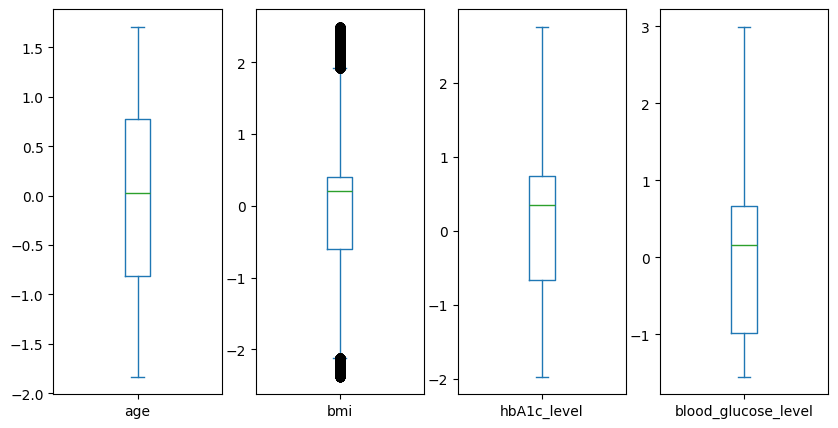

In [190]:
# Gráfico de box and whisker
df[continuous_cols].plot(kind='box', subplots=True, layout=(1,4), sharex=False, sharey=False, figsize=(10,5))
plt.show()

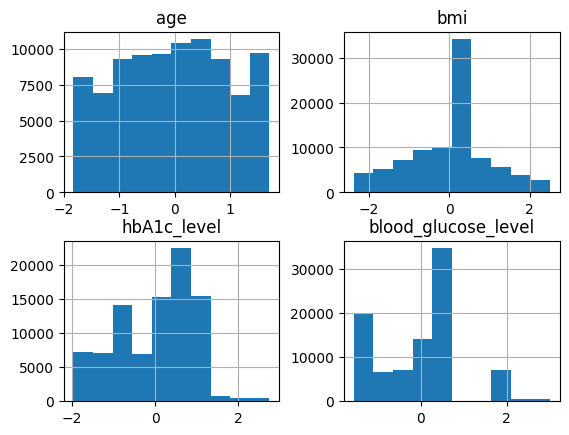

In [191]:
df[continuous_cols].hist() # Histograma
plt.show()

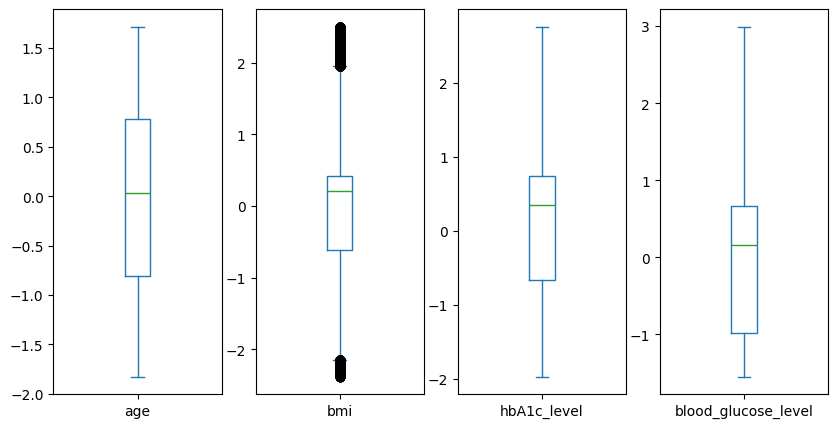

In [192]:
# Gráfico de box and whisker
df_without_location[continuous_cols].plot(kind='box', subplots=True, layout=(1,4), sharex=False, sharey=False, figsize=(10,5))
plt.show()

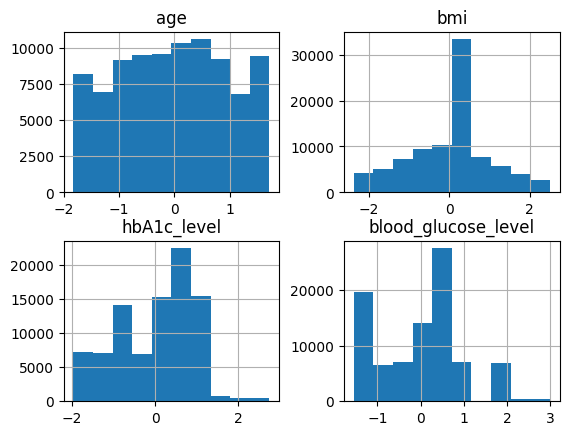

In [193]:
df_without_location[continuous_cols].hist() # Histograma
plt.show()

## Criar conjunto de validação

In [194]:
# Define X como todas as colunas, exceto a coluna "diabetes"
X = df.drop(columns=['diabetes']).values
X_loc = df_without_location.drop(columns=['diabetes']).values
# Define Y como a coluna "diabetes"
Y = df['diabetes'].values
Y_loc = df_without_location['diabetes'].values

# Divide o conjunto em treinamento e validação
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)
X_train_loc, X_validation_loc, Y_train_loc, Y_validation_loc = model_selection.train_test_split(X_loc, Y_loc, test_size=validation_size, random_state=seed)

print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')
print(f'X_validation: {X_validation.shape}, Y_validation: {Y_validation.shape}\n')

print(f'X_train_loc: {X_train_loc.shape}, Y_train_loc: {Y_train_loc.shape}')
print(f'X_validation_loc: {X_validation_loc.shape}, Y_validation_loc: {Y_validation_loc.shape}')

X_train: (72292, 18), Y_train: (72292,)
X_validation: (18073, 18), Y_validation: (18073,)

X_train_loc: (71904, 17), Y_train_loc: (71904,)
X_validation_loc: (17977, 17), Y_validation_loc: (17977,)


## Treinamento dos modelos

- Regressão Logística (LR)
- Análise Linear Discriminante (LDA)
- K-vizinhos mais próximos (KNN)
- Árvores de Classificação (Decision Tree) e Regressão (CART)
- Gaussian Naive Bayes (NB)
- Support Vector Machines (SVM)

In [195]:
# Lista com nomes dos modelos e as classes correspondentes
model_classes = [
  ('LR', OneVsRestClassifier(LogisticRegression(solver='liblinear'))),
  ('LDA', LinearDiscriminantAnalysis()),
  ('KNN', KNeighborsClassifier()),
  ('CART', DecisionTreeClassifier()),
  ('NB', GaussianNB()),
  ('SVM', SVC(gamma='auto'))
]

# Inicializar o dicionário models usando compreensão de dicionário
models = {
  name: {
    'model': model,
    'training_result_mean': 0,
    'training_result_std': 0,
    'validation_result': 0,
    'confusion_matrix': [],
    'classification_report': ''
  }
  for name, model in model_classes
}

models_without_location = models.copy()

# Avaliação de cada modelo
results = [] # Usado para gráfico de comparação
results_without_location = []
names = [] # Usado para gráfico de comparação
names_without_location = []
scoring = 'accuracy'

def treina_modelos(models, X_train, Y_train, X_validation, Y_validation, results, names):
  for name, model in models.items():
    inicio = time()
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)

    # Executa a validação cruzada
    cv_results = model_selection.cross_val_score(model['model'], X_train, Y_train, cv=kfold, scoring=scoring)
    model['training_result_mean'] = cv_results.mean()
    model['training_result_std'] = cv_results.std()

    results.append(cv_results)
    names.append(name)

    model['model'].fit(X_train, Y_train) # Treina o modelo
    predictions = model['model'].predict(X_validation) # Faz previsões

    # Avalia o modelo
    model['validation_result'] = accuracy_score(Y_validation, predictions)
    model['confusion_matrix'] = confusion_matrix(Y_validation, predictions)
    model['classification_report'] = classification_report(Y_validation, predictions)
    fim = time()

    msg = f'{name}: Treinamento: {model['training_result_mean'].round(4)} ({model['training_result_std'].round(4)}) - Validação: {round(model['validation_result'], 4)} - Tempo: {round(fim-inicio, 2)}s'
    print(msg)
    # print(model['confusion_matrix'])
    # print(f"{model['classification_report']}\n")

print('Com a localização:')
treina_modelos(models, X_train, Y_train, X_validation, Y_validation, results, names)
print('\nSem a localização:')
treina_modelos(models_without_location, X_train_loc, Y_train_loc, X_validation_loc, Y_validation_loc, results_without_location, names_without_location)

Com a localização:
LR: Treinamento: 0.9638 (0.0024) - Validação: 0.964 - Tempo: 2.93s
LDA: Treinamento: 0.955 (0.0025) - Validação: 0.9545 - Tempo: 1.27s
KNN: Treinamento: 0.9572 (0.0024) - Validação: 0.9577 - Tempo: 15.23s
CART: Treinamento: 0.9531 (0.0018) - Validação: 0.9557 - Tempo: 2.93s
NB: Treinamento: 0.9042 (0.0031) - Validação: 0.9022 - Tempo: 0.43s
SVM: Treinamento: 0.9641 (0.0019) - Validação: 0.9641 - Tempo: 528.28s

Sem a localização:
LR: Treinamento: 0.9635 (0.0011) - Validação: 0.9644 - Tempo: 2.24s
LDA: Treinamento: 0.9552 (0.0016) - Validação: 0.9543 - Tempo: 2.23s
KNN: Treinamento: 0.9613 (0.0023) - Validação: 0.9622 - Tempo: 17.0s
CART: Treinamento: 0.9534 (0.0014) - Validação: 0.9548 - Tempo: 2.86s
NB: Treinamento: 0.9047 (0.0034) - Validação: 0.9059 - Tempo: 0.42s
SVM: Treinamento: 0.9662 (0.0017) - Validação: 0.9668 - Tempo: 330.6s


Concluímos que a melhor resultado foi obtido com o modelo SVM usando o dataset sem o atributo 'location'.

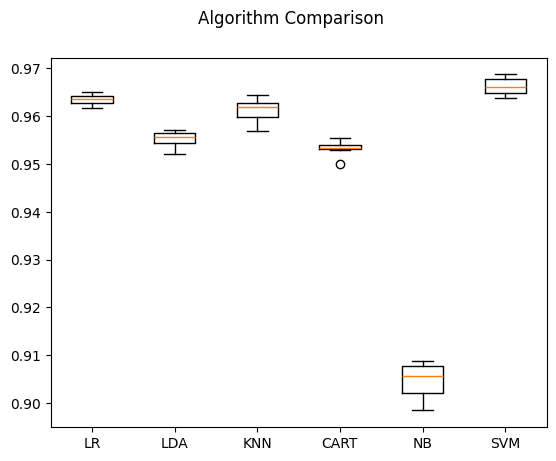

In [196]:
# Comparação dos Algoritmos
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_without_location)
ax.set_xticklabels(names_without_location)
plt.show()

In [197]:
svm = models_without_location['SVM']

print('Algoritmo que obteve o melhor resultado foi o SVM:\n')
print(f'Treinamento: {models_without_location['SVM']['training_result_mean'].round(4)} ({models_without_location['SVM']['training_result_std'].round(4)}) - Validação: {round(models_without_location['SVM']['validation_result'], 4)}')
print(svm['confusion_matrix'])
print(svm['classification_report'])

Algoritmo que obteve o melhor resultado foi o SVM:

Treinamento: 0.9662 (0.0017) - Validação: 0.9668
[[17082     4]
 [  593   298]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17086
           1       0.99      0.33      0.50       891

    accuracy                           0.97     17977
   macro avg       0.98      0.67      0.74     17977
weighted avg       0.97      0.97      0.96     17977



### Exportação do modelo

In [199]:
# salva um novo csv do dataset sem normalizar para ser usado para normalizar as novas entradas antes de fazer a previsão
df_without_location_copy.drop(columns=['diabetes'], inplace=True)
df_without_location_copy.to_csv('./diabetes_prediction/diabetes_dataset_without_normalization.csv', index=False)

joblib.dump(svm['model'], './diabetes_prediction/svm.pkl')

['./diabetes_prediction/svm.pkl']

---

## Validação

In [200]:
entrada_usuario = [
  0, # gender
  31, # age
  0, # race:AfricanAmerican
  0, # race:Asian
  0, # race:Caucasian
  0, # race:Hispanic
  1, # race:Other
  0, # hypertension
  0, # heart_disease
  27.30, # bmi
  4.8, # hbA1c_level
  99, # blood_glucose_level
  0, # smoking_history_current
  0, # smoking_history_ever
  0, # smoking_history_former
  1, # smoking_history_never
  0  # smoking_history_not current
]

In [201]:
# Adiciona a entrada ao dataframe para normalizar
file = './diabetes_prediction/diabetes_dataset_without_normalization.csv'
df = pd.read_csv(f'./{file}', sep=',')

df = pd.concat([df, pd.DataFrame([entrada_usuario], columns=df.columns)], ignore_index=True)
df

gender   age  race:AfricanAmerican  race:Asian  race:Caucasian  \
0           0  32.0                     0           0               0   
1           0  29.0                     0           1               0   
2           1  18.0                     0           0               0   
3           1  41.0                     0           0               1   
4           0  52.0                     1           0               0   
...       ...   ...                   ...         ...             ...   
89877       0  80.0                     0           1               0   
89878       1  46.0                     0           1               0   
89879       0  51.0                     1           0               0   
89880       1  13.0                     0           0               0   
89881       0  31.0                     0           0               0   

       race:Hispanic  race:Other  hypertension  heart_disease    bmi  \
0                  0           1             0              0  27.32   
1                  0           0             0              0  19.95   
2                  0           1             0              0  23.76   
3                  0           0             0              0  27.32   
4                  0           0             0              0  23.75   
...              ...         ...           ...            ...    ...   
89877              0           0             0              0  36.66   
89878              0           0             0              0  36.12   
89879              0           0             0              0  29.29   
89880              1           0             0              0  17.16   
89881              0           1             0              0  27.30   

       hbA1c_level  blood_glucose_level  smoking_history_current  \
0              5.0                  100                        0   
1              5.0                   90                        0   
2              4.8                  160                        0   
3              4.0                  159                        0   
4              6.5                   90                        0   
...            ...                  ...                      ...   
89877          5.7                  100                        0   
89878          6.2                  158                        0   
89879          6.0                  155                        0   
89880          5.0                   90                        0   
89881          4.8                   99                        0   

       smoking_history_ever  smoking_history_former  smoking_history_never  \
0                         0                       0                      1   
1                         0                       0                      1   
2                         0                       0                      1   
3                         0                       0                      1   
4                         0                       0                      1   
...                     ...                     ...                    ...   
89877                     0                       0                      0   
89878                     1                       0                      0   
89879                     0                       0                      0   
89880                     0                       0                      0   
89881                     0                       0                      1   

       smoking_history_not current  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
...                            ...  
89877                            0  
89878                            0  
89879                            1  
89880                            0  
89881                            0  

[89882 rows x 17 columns]

In [202]:
X = df[continuous_cols].values # Extrai valores das colunas contínuas para normalização
X_norm, mu, sigma = normalizar(X) # Normaliza apenas as colunas contínuas
df[continuous_cols] = X_norm # Atualiza as colunas contínuas no DataFrame original com os valores normalizados
df

gender       age  race:AfricanAmerican  race:Asian  race:Caucasian  \
0           0 -0.410851                     0           0               0   
1           0 -0.543853                     0           1               0   
2           1 -1.031526                     0           0               0   
3           1 -0.011845                     0           0               1   
4           0  0.475828                     1           0               0   
...       ...       ...                   ...         ...             ...   
89877       0  1.717178                     0           1               0   
89878       1  0.209824                     0           1               0   
89879       0  0.431494                     1           0               0   
89880       1 -1.253196                     0           0               0   
89881       0 -0.455185                     0           0               0   

       race:Hispanic  race:Other  hypertension  heart_disease       bmi  \
0                  0           1             0              0  0.203890   
1                  0           0             0              0 -1.280860   
2                  0           1             0              0 -0.513303   
3                  0           0             0              0  0.203890   
4                  0           0             0              0 -0.515318   
...              ...         ...           ...            ...       ...   
89877              0           0             0              0  2.085513   
89878              0           0             0              0  1.976725   
89879              0           0             0              0  0.600763   
89880              1           0             0              0 -1.842930   
89881              0           1             0              0  0.199860   

       hbA1c_level  blood_glucose_level  smoking_history_current  \
0        -0.459080            -0.981747                        0   
1        -0.459080            -1.265682                        0   
2        -0.660102             0.721864                        0   
3        -1.464188             0.693471                        0   
4         1.048583            -1.265682                        0   
...            ...                  ...                      ...   
89877     0.244496            -0.981747                        0   
89878     0.747050             0.665077                        0   
89879     0.546029             0.579897                        0   
89880    -0.459080            -1.265682                        0   
89881    -0.660102            -1.010141                        0   

       smoking_history_ever  smoking_history_former  smoking_history_never  \
0                         0                       0                      1   
1                         0                       0                      1   
2                         0                       0                      1   
3                         0                       0                      1   
4                         0                       0                      1   
...                     ...                     ...                    ...   
89877                     0                       0                      0   
89878                     1                       0                      0   
89879                     0                       0                      0   
89880                     0                       0                      0   
89881                     0                       0                      1   

       smoking_history_not current  
0                                0  
1                                0  
2                                0  
3                                0  
4                                0  
...                            ...  
89877                            0  
89878                            0  
89879                            1  
89880                            0  
89881               

In [203]:
# Coleta a última linha do dataframe
entrada_usuario_normalizada = df.iloc[-1].values
entrada_usuario_normalizada

array([ 0.        , -0.45518469,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.19986047,
       -0.66010154, -1.01014057,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ])

In [204]:
# Realiza a previsão
svm_model = joblib.load('./diabetes_prediction/svm.pkl')
previsao = svm_model.predict([entrada_usuario_normalizada])
print("Previsão de diabetes:", previsao[0])

Previsão de diabetes: 0
